# **Stochastic Discrete Ricci Flow with Attention**

The aim of this study is to investigate whether incorporating attention into SDRF is an effective way of making the method sensitive to the node features.

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.1+cu116


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

Much of the code below is copied / adapted from the [SDRF GitHub repository](https://github.com/jctops/understanding-oversquashing ) and [DIGL GitHub repository](https://github.com/gasteigerjo/gdc). Each cell is commented with the corresponding file it was copied / adapted from.

# **Seeds**
Below are the seeds used for the val and test splits. 

In [3]:
# gdl/seeds.py
test_seeds = [
    2406525885,
    3164031153,
    1454191016,
    1583215992,
    765984986,
    258270452,
    3808600642,
    292690791,
    2492579272,
    1660347731,
    902096533,
    1295255868,
    3887601419,
    2250799892,
    4099160157,
    658822373,
    1105377040,
    1822472846,
    2360402805,
    2355749367,
    2291281609,
    1241963358,
    3431144533,
    623424053,
    78533721,
    1819244826,
    1368272433,
    555336705,
    1979924085,
    1064200250,
    256355991,
    125892661,
    4214462414,
    2173868563,
    629150633,
    525931699,
    3859280724,
    1633334170,
    1881852583,
    2776477614,
    1576005390,
    2488832372,
    2518362830,
    2535216825,
    333285849,
    109709634,
    2287562222,
    3519650116,
    3997158861,
    3939456016,
    4049817465,
    2056937834,
    4198936517,
    1928038128,
    897197605,
    3241375559,
    3379824712,
    3094687001,
    80894711,
    1598990667,
    2733558549,
    2514977904,
    3551930474,
    2501047343,
    2838870928,
    2323804206,
    2609476842,
    1941488137,
    1647800118,
    1544748364,
    983997847,
    1907884813,
    1261931583,
    4094088262,
    536998751,
    3788863109,
    4023022221,
    3116173213,
    4019585660,
    3278901850,
    3321752075,
    2108550661,
    2354669019,
    3317723962,
    1915553117,
    1464389813,
    1648766618,
    3423813613,
    1338906396,
    629014539,
    3330934799,
    3295065306,
    3212139042,
    3653474276,
    1078114430,
    2424918363,
    3316305951,
    2059234307,
    1805510917,
    1327514671,
]

val_seeds = [
    4258031807,
    3829679737,
    3706579387,
    789594926,
    3628091752,
    54121625,
    825346923,
    646393804,
    1579300575,
    246132812,
    2882726575,
    970387138,
    413984459,
    288449314,
    1594895720,
    1950255998,
    4015021126,
    3798842978,
    2668546961,
    1254814623,
    1804908540,
    674684671,
    1988664841,
    3361110162,
    3784152546,
    3431665473,
    1487802115,
    1080377472,
    1033325667,
    2068347440,
    50862517,
    1266130159,
    3705237643,
    2523113545,
    1385697073,
    1227694832,
    198559329,
    1464601500,
    490478722,
    3144635527,
    4085231799,
    2935399337,
    3291449301,
    2933074791,
    1604475278,
    2748278770,
    1041151773,
    2302537583,
    1592364233,
    1347718791,
    2260302349,
    2870906085,
    3324642025,
    3383731094,
    3268345887,
    3861549985,
    1839485103,
    2440976226,
    1348632978,
    1730263803,
    3273174762,
    2443236195,
    2018253000,
    3131053563,
    2750855724,
    2142840570,
    133334446,
    2906772286,
    1676623629,
    2799515439,
    1950780225,
    245027879,
    974231345,
    1019551316,
    418468904,
    3645979760,
    2676444879,
    2600212003,
    243207504,
    4050914577,
    395869280,
    3037389484,
    319467089,
    2091061953,
    1121224029,
    1506683900,
    4265586951,
    910928236,
    1175970114,
    2105285287,
    3164711608,
    3255599240,
    894959334,
    493067366,
    3349051410,
    511641138,
    2487307261,
    951126382,
    530590201,
    17966177,
]

development_seed = 1684992425

# **Curvature / SDRF**
The code below applies SDRF to a graph. Note that we have a separate version for CPU and CUDA.

In [4]:
%%capture
!pip install wandb black numba jupyter[lab]

In [5]:
# gdl/curvature/utils.py
import numpy as np

def np_softmax(a, tau=1):
    exp_a = np.exp(a * tau)
    return exp_a / exp_a.sum()

### **CPU**

In [ ]:
# gdl/curvature/numba.py
from numba import jit, prange
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
)


@jit(nopython=True)
def _balanced_forman_curvature(A, A2, d_in, d_out, N, C):
    for i in prange(N):
        for j in prange(N):
            if A[i, j] == 0:
                C[i, j] = 0
                break

            if d_in[i] > d_out[j]:
                d_max = d_in[i]
                d_min = d_out[j]
            else:
                d_max = d_out[j]
                d_min = d_in[i]

            if d_max * d_min == 0:
                C[i, j] = 0
                break

            sharp_ij = 0
            lambda_ij = 0
            for k in range(N):
                TMP = A[k, j] * (A2[i, k] - A[i, k]) * A[i, j]
                if TMP > 0:
                    sharp_ij += 1
                    if TMP > lambda_ij:
                        lambda_ij = TMP

                TMP = A[i, k] * (A2[k, j] - A[k, j]) * A[i, j]
                if TMP > 0:
                    sharp_ij += 1
                    if TMP > lambda_ij:
                        lambda_ij = TMP

            C[i, j] = (
                (2 / d_max)
                + (2 / d_min)
                - 2
                + (2 / d_max + 1 / d_min) * A2[i, j] * A[i, j]
            )
            if lambda_ij > 0:
                C[i, j] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_curvature(A, C=None):
    N = A.shape[0]
    A2 = np.matmul(A, A)
    d_in = A.sum(axis=0)
    d_out = A.sum(axis=1)
    if C is None:
        C = np.zeros((N, N))

    _balanced_forman_curvature(A, A2, d_in, d_out, N, C)
    return C


@jit(nopython=True)
def _balanced_forman_post_delta(
    A, A2, d_in_x, d_out_y, N, D, x, y, i_neighbors, j_neighbors, dim_i, dim_j
):
    for I in prange(dim_i):
        for J in prange(dim_j):
            i = i_neighbors[I]
            j = j_neighbors[J]

            if (i == j) or (A[i, j] != 0):
                D[I, J] = -1000
                break

            # Difference in degree terms
            if j == x:
                d_in_x += 1
            elif i == y:
                d_out_y += 1

            if d_in_x * d_out_y == 0:
                D[I, J] = 0
                break

            if d_in_x > d_out_y:
                d_max = d_in_x
                d_min = d_out_y
            else:
                d_max = d_out_y
                d_min = d_in_x

            # Difference in triangles term
            A2_x_y = A2[x, y]
            if (x == i) and (A[j, y] != 0):
                A2_x_y += A[j, y]
            elif (y == j) and (A[x, i] != 0):
                A2_x_y += A[x, i]

            # Difference in four-cycles term
            sharp_ij = 0
            lambda_ij = 0
            for z in range(N):
                A_z_y = A[z, y] + 0
                A_x_z = A[x, z] + 0
                A2_z_y = A2[z, y] + 0
                A2_x_z = A2[x, z] + 0

                if (z == i) and (y == j):
                    A_z_y += 1
                if (x == i) and (z == j):
                    A_x_z += 1
                if (z == i) and (A[j, y] != 0):
                    A2_z_y += A[j, y]
                if (x == i) and (A[j, z] != 0):
                    A2_x_z += A[j, z]
                if (y == j) and (A[z, i] != 0):
                    A2_z_y += A[z, i]
                if (z == j) and (A[x, i] != 0):
                    A2_x_z += A[x, i]

                TMP = A_z_y * (A2_x_z - A_x_z) * A[x, y]
                if TMP > 0:
                    sharp_ij += 1
                    if TMP > lambda_ij:
                        lambda_ij = TMP

                TMP = A_x_z * (A2_z_y - A_z_y) * A[x, y]
                if TMP > 0:
                    sharp_ij += 1
                    if TMP > lambda_ij:
                        lambda_ij = TMP

            D[I, J] = (
                (2 / d_max)
                + (2 / d_min)
                - 2
                + (2 / d_max + 1 / d_min) * A2_x_y * A[x, y]
            )
            if lambda_ij > 0:
                D[I, J] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_post_delta(A, x, y, i_neighbors, j_neighbors, D=None):
    N = A.shape[0]
    A2 = np.matmul(A, A)
    d_in = A[:, x].sum()
    d_out = A[y].sum()
    if D is None:
        D = np.zeros((len(i_neighbors), len(j_neighbors)))

    _balanced_forman_post_delta(
        A,
        A2,
        d_in,
        d_out,
        N,
        D,
        x,
        y,
        np.array(i_neighbors),
        np.array(j_neighbors),
        D.shape[0],
        D.shape[1],
    )
    return D


def sdrf(
    data,
    loops=10,
    remove_edges=True,
    removal_bound=0.5,
    tau=1,
    is_undirected=False,
):
    N = data.x.shape[0]
    A = np.zeros(shape=(N, N))
    if is_undirected:
        for i, j in zip(data.edge_index[0], data.edge_index[1]):
            if i != j:
                A[i, j] = A[j, i] = 1.0
    else:
        for i, j in zip(data.edge_index[0], data.edge_index[1]):
            if i != j:
                A[i, j] = 1.0
    N = A.shape[0]
    G = to_networkx(data)
    if is_undirected:
        G = G.to_undirected()
    C = np.zeros((N, N))

    for x in range(loops):
        can_add = True
        balanced_forman_curvature(A, C=C)
        ix_min = C.argmin()
        x = ix_min // N
        y = ix_min % N

        if is_undirected:
            x_neighbors = list(G.neighbors(x)) + [x]
            y_neighbors = list(G.neighbors(y)) + [y]
        else:
            x_neighbors = list(G.successors(x)) + [x]
            y_neighbors = list(G.predecessors(y)) + [y]
        candidates = []
        for i in x_neighbors:
            for j in y_neighbors:
                if (i != j) and (not G.has_edge(i, j)):
                    candidates.append((i, j))

        if len(candidates):
            D = balanced_forman_post_delta(A, x, y, x_neighbors, y_neighbors)
            improvements = []
            for (i, j) in candidates:
                improvements.append(
                    (D - C[x, y])[x_neighbors.index(i), y_neighbors.index(j)]
                )

            k, l = candidates[
                np.random.choice(
                    range(len(candidates)), p=np_softmax(np.array(improvements), tau=tau)
                )
            ]
            G.add_edge(k, l)
            if is_undirected:
                A[k, l] = A[l, k] = 1
                added_edges.append((k, l))
                added_edges.append((l, k))
            else:
                A[k, l] = 1
                added_edges.append((k, l))
        else:
            can_add = False
            if not remove_edges:
                break

        if remove_edges:
            ix_max = C.argmax()
            x = ix_max // N
            y = ix_max % N
            if C[x, y] > removal_bound:
                G.remove_edge(x, y)
                if is_undirected:
                    A[x, y] = A[y, x] = 0
                    removed_edges.append((x, y))
                    removed_edges.append((y, x))
                else:
                    A[x, y] = 0
                    removed_edges.append((x, y))
            else:
                if can_add is False:
                    break

    return from_networkx(G)

### **CUDA**

In [6]:
# gdl/curvature/cuda.py
import math
from numba import cuda
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)


@cuda.jit(
    "void(float32[:,:], float32[:,:], float32[:], float32[:], int32, float32[:,:])"
)
def _balanced_forman_curvature(A, A2, d_in, d_out, N, C):
    i, j = cuda.grid(2)

    if (i < N) and (j < N):
        if A[i, j] == 0:
            C[i, j] = 0
            return

        if d_in[i] > d_out[j]:
            d_max = d_in[i]
            d_min = d_out[j]
        else:
            d_max = d_out[j]
            d_min = d_in[i]

        if d_max * d_min == 0:
            C[i, j] = 0
            return

        sharp_ij = 0
        lambda_ij = 0
        for k in range(N):
            TMP = A[k, j] * (A2[i, k] - A[i, k]) * A[i, j]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

            TMP = A[i, k] * (A2[k, j] - A[k, j]) * A[i, j]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

        C[i, j] = (
            (2 / d_max) + (2 / d_min) - 2 + (2 / d_max + 1 / d_min) * A2[i, j] * A[i, j]
        )
        if lambda_ij > 0:
            C[i, j] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_curvature(A, C=None):
    N = A.shape[0]
    A2 = torch.matmul(A, A)
    d_in = A.sum(axis=0)
    d_out = A.sum(axis=1)
    if C is None:
        C = torch.zeros(N, N).cuda()

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(N / threadsperblock[0])
    blockspergrid_y = math.ceil(N / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    _balanced_forman_curvature[blockspergrid, threadsperblock](A, A2, d_in, d_out, N, C)
    return C


@cuda.jit(
    "void(float32[:,:], float32[:,:], float32, float32, int32, float32[:,:], int32, int32, int32[:], int32[:], int32, int32)"
)
def _balanced_forman_post_delta(
    A, A2, d_in_x, d_out_y, N, D, x, y, i_neighbors, j_neighbors, dim_i, dim_j
):
    I, J = cuda.grid(2)

    if (I < dim_i) and (J < dim_j):
        i = i_neighbors[I]
        j = j_neighbors[J]

        if (i == j) or (A[i, j] != 0):
            D[I, J] = -1000
            return

        # Difference in degree terms
        if j == x:
            d_in_x += 1
        elif i == y:
            d_out_y += 1

        if d_in_x * d_out_y == 0:
            D[I, J] = 0
            return

        if d_in_x > d_out_y:
            d_max = d_in_x
            d_min = d_out_y
        else:
            d_max = d_out_y
            d_min = d_in_x

        # Difference in triangles term
        A2_x_y = A2[x, y]
        if (x == i) and (A[j, y] != 0):
            A2_x_y += A[j, y]
        elif (y == j) and (A[x, i] != 0):
            A2_x_y += A[x, i]

        # Difference in four-cycles term
        sharp_ij = 0
        lambda_ij = 0
        for z in range(N):
            A_z_y = A[z, y] + 0
            A_x_z = A[x, z] + 0
            A2_z_y = A2[z, y] + 0
            A2_x_z = A2[x, z] + 0

            if (z == i) and (y == j):
                A_z_y += 1
            if (x == i) and (z == j):
                A_x_z += 1
            if (z == i) and (A[j, y] != 0):
                A2_z_y += A[j, y]
            if (x == i) and (A[j, z] != 0):
                A2_x_z += A[j, z]
            if (y == j) and (A[z, i] != 0):
                A2_z_y += A[z, i]
            if (z == j) and (A[x, i] != 0):
                A2_x_z += A[x, i]

            TMP = A_z_y * (A2_x_z - A_x_z) * A[x, y]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

            TMP = A_x_z * (A2_z_y - A_z_y) * A[x, y]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

        D[I, J] = (
            (2 / d_max) + (2 / d_min) - 2 + (2 / d_max + 1 / d_min) * A2_x_y * A[x, y]
        )
        if lambda_ij > 0:
            D[I, J] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_post_delta(A, x, y, i_neighbors, j_neighbors, D=None):
    N = A.shape[0]
    A2 = torch.matmul(A, A)
    d_in = A[:, x].sum()
    d_out = A[y].sum()
    if D is None:
        D = torch.zeros(len(i_neighbors), len(j_neighbors)).cuda()

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(D.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(D.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    _balanced_forman_post_delta[blockspergrid, threadsperblock](
        A,
        A2,
        d_in,
        d_out,
        N,
        D,
        x,
        y,
        np.array(i_neighbors),
        np.array(j_neighbors),
        D.shape[0],
        D.shape[1],
    )
    return D


def sdrf(
    data,
    loops=10,
    remove_edges=True,
    removal_bound=0.5,
    tau=1,
    is_undirected=False,
):
    edge_index = data.edge_index
    if is_undirected:
        edge_index = to_undirected(edge_index)
    A = to_dense_adj(remove_self_loops(edge_index)[0])[0]
    N = A.shape[0]
    G = to_networkx(data)
    if is_undirected:
        G = G.to_undirected()
    A = A.cuda()
    C = torch.zeros(N, N).cuda()

    for x in range(loops):
        can_add = True
        balanced_forman_curvature(A, C=C)
        ix_min = C.argmin().item()
        x = ix_min // N
        y = ix_min % N
        
        if is_undirected:
            x_neighbors = list(G.neighbors(x)) + [x]
            y_neighbors = list(G.neighbors(y)) + [y]
        else:
            x_neighbors = list(G.successors(x)) + [x]
            y_neighbors = list(G.predecessors(y)) + [y]
        candidates = []
        for i in x_neighbors:
            for j in y_neighbors:
                if (i != j) and (not G.has_edge(i, j)):
                    candidates.append((i, j))

        if len(candidates):
            D = balanced_forman_post_delta(A, x, y, x_neighbors, y_neighbors)
            improvements = []
            for (i, j) in candidates:
                improvements.append(
                    (D - C[x, y])[x_neighbors.index(i), y_neighbors.index(j)].item()
                )

            k, l = candidates[
                np.random.choice(
                    range(len(candidates)), p=np_softmax(np.array(improvements), tau=tau)
                )
            ]
            G.add_edge(k, l)
            if is_undirected:
                A[k, l] = A[l, k] = 1
                added_edges.add((k, l))
                added_edges.add((l, k))
                removed_edges.discard((k, l))
                removed_edges.discard((l, k))
            else:
                A[k, l] = 1
                added_edges.add((k, l))
                removed_edges.discard((k, l))
        else:
            can_add = False
            if not remove_edges:
                break

        if remove_edges:
            ix_max = C.argmax().item()
            x = ix_max // N
            y = ix_max % N
            if C[x, y] > removal_bound:
                G.remove_edge(x, y)
                if is_undirected:
                    A[x, y] = A[y, x] = 0
                    removed_edges.add((x, y))
                    removed_edges.add((y, x))
                    added_edges.discard((x, y))
                    added_edges.discard((y, x))
                else:
                    A[x, y] = 0
                    removed_edges.add((x, y))
                    added_edges.discard((x, y))
            else:
                if can_add is False:
                    break

    return from_networkx(G)

# **Data**
The code below builds SDRF datasets.

In [7]:
# gdl/data/utils.py
from torch_geometric.data import InMemoryDataset


def get_adj_matrix(dataset: InMemoryDataset) -> np.ndarray:
    num_nodes = dataset.data.x.shape[0]
    adj_matrix = np.zeros(shape=(num_nodes, num_nodes))
    for i, j in zip(dataset.data.edge_index[0], dataset.data.edge_index[1]):
        adj_matrix[i, j] = 1.0
    return adj_matrix


def get_undirected_adj_matrix(dataset: InMemoryDataset) -> np.ndarray:
    num_nodes = dataset.data.x.shape[0]
    adj_matrix = np.zeros(shape=(num_nodes, num_nodes))
    for i, j in zip(dataset.data.edge_index[0], dataset.data.edge_index[1]):
        adj_matrix[i, j] = 1.0
        adj_matrix[j, i] = 1.0
    return adj_matrix


def get_top_k_matrix(A: np.ndarray, k: int = 128) -> np.ndarray:
    num_nodes = A.shape[0]
    row_idx = np.arange(num_nodes)
    A[A.argsort(axis=0)[: num_nodes - k], row_idx] = 0.0
    norm = A.sum(axis=0)
    norm[norm <= 0] = 1  # avoid dividing by zero
    return A / norm


def get_clipped_matrix(A: np.ndarray, eps: float = 0.01) -> np.ndarray:
    num_nodes = A.shape[0]
    A[A < eps] = 0.0
    norm = A.sum(axis=0)
    norm[norm <= 0] = 1  # avoid dividing by zero
    return A / norm

In [8]:
# gdl/data/base.py
from torch_geometric.data import Data
from torch_geometric.datasets import (
    Planetoid,
    Amazon,
    Coauthor,
    WebKB,
    WikipediaNetwork,
    Actor,
)
import os

DEFAULT_DATA_PATH = "data"


def get_node_mapper(lcc: np.ndarray) -> dict:
    mapper = {}
    counter = 0
    for node in lcc:
        mapper[node] = counter
        counter += 1
    return mapper


def remap_edges(edges: list, mapper: dict) -> list:
    row = [e[0] for e in edges]
    col = [e[1] for e in edges]
    row = list(map(lambda x: mapper[x], row))
    col = list(map(lambda x: mapper[x], col))
    return [row, col]


def get_component(dataset: InMemoryDataset, start: int = 0) -> set:
    visited_nodes = set()
    queued_nodes = set([start])
    row, col = dataset.data.edge_index.numpy()
    while queued_nodes:
        current_node = queued_nodes.pop()
        visited_nodes.update([current_node])
        neighbors = col[np.where(row == current_node)[0]]
        neighbors = [
            n for n in neighbors if n not in visited_nodes and n not in queued_nodes
        ]
        queued_nodes.update(neighbors)
    return visited_nodes


def get_largest_connected_component(dataset: InMemoryDataset) -> np.ndarray:
    remaining_nodes = set(range(dataset.data.x.shape[0]))
    comps = []
    while remaining_nodes:
        start = min(remaining_nodes)
        comp = get_component(dataset, start)
        comps.append(comp)
        remaining_nodes = remaining_nodes.difference(comp)
    return np.array(list(comps[np.argmax(list(map(len, comps)))]))


def get_dataset(
    name: str, use_lcc: bool = True, data_dir=DEFAULT_DATA_PATH
) -> InMemoryDataset:
    path = os.path.join(data_dir, name)
    if name in ["Cora", "Citeseer", "Pubmed"]:
        dataset = Planetoid(path, name)
    elif name in ["Computers", "Photo"]:
        dataset = Amazon(path, name)
    elif name == "CoauthorCS":
        dataset = Coauthor(path, "CS")
    elif name in ["Cornell", "Texas", "Wisconsin"]:
        dataset = WebKB(path, name)
    elif name in ["Chameleon", "Squirrel"]:
        dataset = WikipediaNetwork(path, name, geom_gcn_preprocess=True)
    elif name == "Actor":
        dataset = Actor(path, "Actor")
    else:
        raise Exception(f"Unknown dataset: {name}")

    if use_lcc:
        lcc = get_largest_connected_component(dataset)

        x_new = dataset.data.x[lcc]
        y_new = dataset.data.y[lcc]

        row, col = dataset.data.edge_index.numpy()
        edges = [[i, j] for i, j in zip(row, col) if i in lcc and j in lcc]
        edges = remap_edges(edges, get_node_mapper(lcc))

        data = Data(
            x=x_new,
            edge_index=torch.LongTensor(edges),
            y=y_new,
            train_mask=torch.zeros(y_new.size()[0], dtype=torch.bool),
            test_mask=torch.zeros(y_new.size()[0], dtype=torch.bool),
            val_mask=torch.zeros(y_new.size()[0], dtype=torch.bool),
        )
        dataset.data = data

    mapping = dict(
        zip(np.unique(dataset.data.y), range(len(np.unique(dataset.data.y))))
    )
    dataset.data.y = torch.LongTensor([mapping[u] for u in np.array(dataset.data.y)])

    return dataset


class BaseDataset(InMemoryDataset):
    """
    Data preprocessed by being made undirected.
    """

    def __init__(
        self,
        name: str = "Cora",
        use_lcc: bool = True,
        undirected: bool = False,
        data_dir: str = None,
    ):
        self.name = name
        self.use_lcc = use_lcc
        self.undirected = undirected
        self.init(data_dir)

    def init(self, data_dir):
        if data_dir is None:
            data_dir = DEFAULT_DATA_PATH
        self.data_dir = data_dir

        super(BaseDataset, self).__init__(self.data_dir)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self) -> list:
        return []

    @property
    def processed_file_names(self) -> list:
        return [str(self) + ".pt"]

    def download(self):
        pass

    def get_dataset(self):
        return get_dataset(name=self.name, use_lcc=self.use_lcc, data_dir=self.data_dir)

    def to_dataset(self, base, edge_index, edge_attr):
        data = Data(
            x=base.data.x,
            edge_index=torch.LongTensor(edge_index),
            edge_attr=torch.FloatTensor(edge_attr) if edge_attr is not None else None,
            y=base.data.y,
            train_mask=torch.zeros(base.data.train_mask.size()[0], dtype=torch.bool),
            test_mask=torch.zeros(base.data.test_mask.size()[0], dtype=torch.bool),
            val_mask=torch.zeros(base.data.val_mask.size()[0], dtype=torch.bool),
        )

        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

    def process(self):
        """
        Overwrites of this method must start with self.get_dataset() and
        end with self.to_dataset(base, edge_index, edge_attr).
        """
        base = self.get_dataset()

        # remove making directed graphs undirected
        # if not self.undirected:
        #     adj_matrix = get_undirected_adj_matrix(base)
        #     edges_i = []
        #     edges_j = []
        #     edge_attr = []
        #     for i, row in enumerate(adj_matrix):
        #         for j in np.where(row > 0)[0]:
        #             edges_i.append(i)
        #             edges_j.append(j)
        #             edge_attr.append(adj_matrix[i, j])
        #     edge_index = [edges_i, edges_j]
        # else:
        edge_index = base.data.edge_index
        edge_attr = (
            base.data.edge_attr if "edge_attr" in base.data.__dir__() else None
        )

        self.to_dataset(base, edge_index, edge_attr)

    def __str__(self) -> str:
        return f"{self.name}_{'base' if not self.undirected else 'undirected'}_lcc={self.use_lcc}"

In [9]:
# gdl/data/sdrf.py
class SDRFDataset(BaseDataset):
    """
    Dataset preprocessed with SDRF (Cuda version).
    """

    def __init__(
        self,
        name: str = "Cora",
        use_lcc: bool = True,
        max_steps: int = None,
        remove_edges: bool = True,
        removal_bound: float = 0.5,
        tau: float = 1,
        undirected: bool = False,
        data_dir: str = None,
    ):
        self.name = name
        self.use_lcc = use_lcc
        self.max_steps = int(max_steps)
        self.remove_edges = remove_edges
        self.removal_bound = removal_bound
        self.tau = tau
        self.undirected = undirected
        super(SDRFDataset, self).init(data_dir)

    def process(self):
        base = self.get_dataset()
        altered_data = sdrf(
            base.data,
            loops=self.max_steps,
            remove_edges=self.remove_edges,
            tau=self.tau,
            is_undirected=self.undirected,
        )
        edge_index = altered_data.edge_index
        self.to_dataset(base, edge_index, None)

    def __str__(self) -> str:
        return (
            f"{self.name}_sdrf_ms={self.max_steps}_re={self.remove_edges}_rb={self.removal_bound}_tau={self.tau}_lcc={self.use_lcc}"
            + ("_undirected" if self.undirected else "")
        )

# **Models**
The code for our GCN models.

In [10]:
from typing import List, Tuple, Set
from torch.nn import ModuleList, Dropout, ReLU
from torch_geometric.nn import GCNConv
import torch.nn as nn


class GCN(torch.nn.Module):
    def __init__(
        self, dataset: InMemoryDataset, hidden: List[int] = [64], dropout: float = 0.5
    ):
        super(GCN, self).__init__()

        num_features = [dataset.data.x.shape[1]] + hidden + [dataset.num_classes]
        layers = []
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            layers.append(GCNConv(in_features, out_features))
        self.layers = ModuleList(layers)

        self.reg_params = list(layers[0].parameters())
        self.non_reg_params = list([p for l in layers[1:] for p in l.parameters()])

        self.dropout = Dropout(p=dropout)
        self.act_fn = ReLU()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, data: Data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index, edge_weight=edge_attr)

            if i == len(self.layers) - 1:
                break

            x = self.act_fn(x)
            x = self.dropout(x)

        return torch.nn.functional.log_softmax(x, dim=1)

In [11]:
import torch_scatter


class GCN_Att(torch.nn.Module):
    def __init__(
        self, 
        dataset: InMemoryDataset,
        undirected: bool,
        sdrf_only: bool,
        use_edge_type_indicator: bool,
        use_bfc_edge_feat: bool,
        device: str,
        hidden: List[int] = [64], 
        dropout: float = 0.5
    ):
        super(GCN_Att, self).__init__()

        num_features = [dataset.data.x.shape[1]] + hidden + [dataset.num_classes]
        layers = []
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            layers.append(GCNConv(in_features, out_features))
        self.layers = ModuleList(layers)

        self.reg_params = list(layers[0].parameters())
        self.non_reg_params = list([p for l in layers[1:] for p in l.parameters()])

        self.dropout = Dropout(p=dropout)
        self.act_fn = ReLU()

        self.undirected = undirected
        self.sdrf_only = sdrf_only
        self.use_bfc_edge_feat = use_bfc_edge_feat
        self.use_edge_type_indicator = use_edge_type_indicator
        self.device = device

        self.modified_edge_index = None # edge_index with edges removed by SDRF added back in
        self.edge_mask = None # mask of which edges are added/removed by SDRF
        self.edge_type_indicator = None # tensor which indicates whether edge added, removed, or neither by SDRF
        self.bfc_edge_feat = None # tensor with bfc score for each edge in self.modified_edge_index

        # parameters for computing edge weights
        extra_feat = 0
        if use_edge_type_indicator:
            extra_feat += 3
        if use_bfc_edge_feat:
            extra_feat += 1
        self.W = nn.Linear(num_features[0] * 2 + extra_feat, num_features[1], bias=False)
        self.a = nn.Linear(num_features[1], 1, bias=False)
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.2)
        self.Sigmoid = nn.Sigmoid()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index

        edge_weight = self.compute_edge_weight(data, x, edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.modified_edge_index, edge_weight=edge_weight)

            if i == len(self.layers) - 1:
                break

            x = self.act_fn(x)
            x = self.dropout(x)

        return torch.nn.functional.log_softmax(x, dim=1)

    def compute_edge_weight(self, data, x, edge_index):
        # first time initialisation
        if self.modified_edge_index is None:
            # add removed edges
            g = to_networkx(data, to_undirected=self.undirected)
            g.add_edges_from(removed_edges)
            # add self loops if sdrf_only is False, so that self loops are included in attention calculation
            # this is necessary because GCN adds self loops automatically
            if not self.sdrf_only:
                g.add_edges_from([(i, i) for i in list(g.nodes)])
            self.modified_edge_index = from_networkx(g).edge_index.to(self.device)

            # build edge mask and edge_type_indicator
            edges = self.modified_edge_index.tolist()
            edge_mask = []
            edge_type_indicator = [] # [added, removed, neither]
            for edge in zip(edges[0], edges[1]):
                if edge in added_edges:
                    edge_type_indicator.append([1.0, 0.0, 0.0])
                    edge_mask.append(True)
                elif edge in removed_edges:
                    edge_type_indicator.append([0.0, 1.0, 0.0])
                    edge_mask.append(True)
                else:
                    edge_type_indicator.append([0.0, 0.0, 1.0])
                    edge_mask.append(False)
            self.edge_mask = torch.tensor(edge_mask).to(self.device)
            self.edge_type_indicator = torch.tensor(edge_type_indicator).to(self.device)

            # build bfc edge features
            if self.use_bfc_edge_feat:
                A = to_dense_adj(self.modified_edge_index)[0].to(self.device)
                N = A.shape[0]
                C = torch.zeros(N, N).to(self.device)
                balanced_forman_curvature(A, C=C) # run bfc
                bfc_edge_feat = [C[x][y] for x, y in zip(edges[0], edges[1])]
                self.bfc_edge_feat = torch.tensor(bfc_edge_feat).unsqueeze(1).to(self.device)            
        
        source, dest = self.modified_edge_index
        h_i = x[source] # features for source nodes
        h_j = x[dest] # features for destination nodes

        # compute attention scores e
        cat_list = [h_i, h_j]
        if self.use_edge_type_indicator:
            cat_list.append(self.edge_type_indicator)
        if self.use_bfc_edge_feat:
            cat_list.append(self.bfc_edge_feat)
        h_concat = torch.concat(cat_list, dim=1)
        e = self.a(self.LeakyReLU(self.W(h_concat))).squeeze()

        # compute attention weights
        if self.sdrf_only:
            edge_weight = self.Sigmoid(e)
            edge_weight = edge_weight.masked_fill(torch.logical_not(self.edge_mask), 1) # remove weights for edges not added / removed by SDRF
        else:
            edge_weight_logits = torch.exp(e)
            denom = torch_scatter.scatter(edge_weight_logits, dest, dim=0, reduce='sum')
            edge_weight = torch.div(edge_weight_logits, denom[dest]) # softmax over neighbours
        return edge_weight

# **Experiment**
The code below is used for our experiments

In [12]:
# gdl/experiment/splits.py
from math import ceil
import random
from torch_geometric.data import Data


def set_train_val_test_split(
        seed: int,
        data: Data,
        development_frac: float = 0.5,
        num_per_class: int = 20) -> Data:
    rnd_state = np.random.RandomState(development_seed)
    num_nodes = data.y.shape[0]

    num_development = ceil(development_frac * num_nodes)

    development_idx = rnd_state.choice(num_nodes, num_development, replace=False)
    test_idx = [i for i in np.arange(num_nodes) if i not in development_idx]

    train_idx = []
    rnd_state = np.random.RandomState(seed)
    for c in range(data.y.max() + 1):
        class_idx = development_idx[np.where(data.y[development_idx].cpu() == c)[0]]
        train_idx.extend(rnd_state.choice(class_idx, min(num_per_class, ceil(len(class_idx) * 0.5)), replace=False))

    val_idx = [i for i in development_idx if i not in train_idx]

    def get_mask(idx):
        mask = torch.zeros(num_nodes, dtype=torch.bool)
        mask[idx] = 1
        return mask

    data.train_mask = get_mask(train_idx)
    data.val_mask = get_mask(val_idx)
    data.test_mask = get_mask(test_idx)

    return data
    

def set_train_val_test_split_frac(seed: int, data: Data, val_frac: float, test_frac: float):
    num_nodes = data.y.shape[0]

    val_size = ceil(val_frac * num_nodes)
    test_size = ceil(test_frac * num_nodes)
    train_size = num_nodes - val_size - test_size

    nodes = list(range(num_nodes))

    # Take same test set every time using development seed for robustness
    random.seed(development_seed)
    random.shuffle(nodes)
    test_idx = sorted(nodes[:test_size])
    nodes = [x for x in nodes if x not in test_idx]

    # Take train / val split according to seed
    random.seed(seed)
    random.shuffle(nodes)
    train_idx = sorted(nodes[:train_size])
    val_idx = sorted(nodes[train_size:])
    
    assert len(train_idx) + len(val_idx) + len(test_idx) == num_nodes

    def get_mask(idx):
        mask = torch.zeros(num_nodes, dtype=torch.bool)
        mask[idx] = 1
        return mask

    data.train_mask = get_mask(train_idx)
    data.val_mask = get_mask(val_idx)
    data.test_mask = get_mask(test_idx)

    return data

In [13]:
# gdl/experiment/optimizer.py
def get_optimizer(name, model, lr, weight_decay=0):
    if isinstance(name, str):
        name = name.lower()
    else:
        raise Exception("Unsupported optimizer: {}".format(name))
    
    parameters = [
        {'params': model.non_reg_params, 'weight_decay': 0},
        {'params': model.reg_params, 'weight_decay': weight_decay}
    ]
    if name == 'sgd':
        return torch.optim.SGD(parameters, lr=lr)
    elif name == 'rmsprop':
        return torch.optim.RMSprop(parameters, lr=lr)
    elif name == 'adagrad':
        return torch.optim.Adagrad(parameters, lr=lr)
    elif name == 'adam':
        return torch.optim.Adam(parameters, lr=lr)
    elif name == 'adamax':
        return torch.optim.Adamax(parameters, lr=lr)
    else:
        raise Exception("Unsupported optimizer: {}".format(name))

In [14]:
# gdl/experiment/node_classification.py
from torch.optim import Optimizer
import torch.nn.functional as F


def train(model: torch.nn.Module, optimizer: Optimizer, data: Data):
    model.train()
    optimizer.zero_grad()
    logits = model(data)
    loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model: torch.nn.Module, data: Data, test: bool):
    model.eval()
    with torch.no_grad():
        logits = model(data)
    eval_dict = {}
    keys = ['val', 'test'] if test else ['val']
    for key in keys:
        mask = data[f'{key}_mask']
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        eval_dict[f'{key}_acc'] = acc
    return eval_dict

In [15]:
# gdc/gdc_demo.py
import time
from collections import defaultdict
from tqdm.notebook import tqdm


def run(dataset: InMemoryDataset,
        model: torch.nn.Module,
        seeds: np.ndarray,
        test: bool = False,
        max_epochs: int = 10000,
        patience: int = 100,
        lr: float = 0.01,
        weight_decay: float = 0.01,
        development_frac: float = 0.6, # if this is -ve, we're doing 60/20/20 split; not the best code, but it'll do
        device: str = 'cuda',
        optimizer_name: str = 'adam'):
    start_time = time.perf_counter()

    best_dict = defaultdict(list)

    cnt = 0
    for seed in tqdm(seeds):
        if development_frac >= 0.0:
            dataset.data = set_train_val_test_split(
                seed,
                dataset.data,
                development_frac=development_frac,
            ).to(device)
        else: # 60/20/20 split
            dataset.data = set_train_val_test_split_frac(
                seed,
                dataset.data,
                val_frac=0.2,
                test_frac=0.2,
            ).to(device)
        model.to(device).reset_parameters()
        optimizer = get_optimizer(optimizer_name, model, lr, weight_decay)
        patience_counter = 0
        tmp_dict = {'val_acc': 0}

        for epoch in range(1, max_epochs + 1):
            if patience_counter == patience:
                break

            train(model, optimizer, dataset.data)
            eval_dict = evaluate(model, dataset.data, test)

            if eval_dict['val_acc'] < tmp_dict['val_acc']:
                patience_counter += 1
            else:
                patience_counter = 0
                tmp_dict['epoch'] = epoch
                for k, v in eval_dict.items():
                    tmp_dict[k] = v

        for k, v in tmp_dict.items():
            best_dict[k].append(v)
            
    best_dict['duration'] = time.perf_counter() - start_time
    return dict(best_dict)

## **Base**

In [16]:
import seaborn as sns


def base_experiment(name: str,
                    undirected: bool,
                    data_dir: str,
                    hidden: List[int],
                    dropout: float,
                    seeds: np.ndarray,
                    test: bool,
                    lr: float,
                    weight_decay: float,
                    development_frac: float,
                    device: str,
                    optimizer: str):

    base_dataset = BaseDataset(name, undirected=undirected, data_dir=data_dir)

    gcn = GCN(base_dataset, hidden, dropout)

    results = run(base_dataset, gcn, seeds, test=test, lr=lr, weight_decay=weight_decay, development_frac=development_frac, device=device, optimizer_name=optimizer)

    boots_series = sns.algorithms.bootstrap(results['val_acc'], func=np.mean, n_boot=1000)
    results['val_acc_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - np.mean(results['val_acc'])))
    if 'test_acc' in results:
        boots_series = sns.algorithms.bootstrap(results['test_acc'], func=np.mean, n_boot=1000)
        results['test_acc_ci'] = np.max(
            np.abs(sns.utils.ci(boots_series, 95) - np.mean(results['test_acc']))
        )

    for k, v in results.items():
        if 'acc_ci' not in k and k != 'duration':
            results[k] = np.mean(results[k])

    mean_acc = results['test_acc']
    uncertainty = results['test_acc_ci']
    print(f"Mean accuracy: {100 * mean_acc:.2f} +- {100 * uncertainty:.2f}%")

## **SDRF**

In [17]:
def sdrf_experiment(name: str,
                    max_steps: int,
                    tau: int,
                    removal_bound: float,
                    undirected: bool,
                    data_dir: str,
                    hidden: List[int],
                    dropout: float,
                    seeds: np.ndarray,
                    test: bool,
                    lr: float,
                    weight_decay: float,
                    development_frac: float,
                    device: str,
                    optimizer: str):

    sdrf_dataset = SDRFDataset(name, max_steps=max_steps, tau=tau, removal_bound=removal_bound, undirected=undirected, data_dir=data_dir)

    if undirected:
        print(f"Added {len(added_edges) // 2} edges. Removed {len(removed_edges) // 2} edges.")
    else:
        print(f"Added {len(added_edges)} edges. Removed {len(removed_edges)} edges.")

    gcn = GCN(sdrf_dataset, hidden, dropout)

    results = run(sdrf_dataset, gcn, seeds, test=test, lr=lr, weight_decay=weight_decay, development_frac=development_frac, device=device, optimizer_name=optimizer)

    boots_series = sns.algorithms.bootstrap(results['val_acc'], func=np.mean, n_boot=1000)
    results['val_acc_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - np.mean(results['val_acc'])))
    if 'test_acc' in results:
        boots_series = sns.algorithms.bootstrap(results['test_acc'], func=np.mean, n_boot=1000)
        results['test_acc_ci'] = np.max(
            np.abs(sns.utils.ci(boots_series, 95) - np.mean(results['test_acc']))
        )

    for k, v in results.items():
        if 'acc_ci' not in k and k != 'duration':
            results[k] = np.mean(results[k])

    mean_acc = results['test_acc']
    uncertainty = results['test_acc_ci']
    print(f"Mean accuracy: {100 * mean_acc:.2f} +- {100 * uncertainty:.2f}%")

## **SDRF with Attention**

In [18]:
def sdrf_att_experiment(name: str,
                    max_steps: int,
                    tau: int,
                    removal_bound: float,
                    undirected: bool,
                    data_dir: str,
                    sdrf_only: bool,
                    use_edge_type_indicator: bool,
                    use_bfc_edge_feat: bool,
                    hidden: List[int],
                    dropout: float,
                    seeds: np.ndarray,
                    test: bool,
                    lr: float,
                    weight_decay: float,
                    development_frac: float,
                    device: str,
                    optimizer: str):

    sdrf_dataset = SDRFDataset(name, max_steps=max_steps, tau=tau, removal_bound=removal_bound, undirected=undirected, data_dir=data_dir)

    if undirected:
        print(f"Added {len(added_edges) // 2} edges. Removed {len(removed_edges) // 2} edges.")
    else:
        print(f"Added {len(added_edges)} edges. Removed {len(removed_edges)} edges.")

    gcn_att = GCN_Att(sdrf_dataset, undirected, sdrf_only, use_edge_type_indicator, use_bfc_edge_feat, device, hidden, dropout)

    results = run(sdrf_dataset, gcn_att, seeds, test=test, lr=lr, weight_decay=weight_decay, development_frac=development_frac, device=device, optimizer_name=optimizer)

    boots_series = sns.algorithms.bootstrap(results['val_acc'], func=np.mean, n_boot=1000)
    results['val_acc_ci'] = np.max(np.abs(sns.utils.ci(boots_series, 95) - np.mean(results['val_acc'])))
    if 'test_acc' in results:
        boots_series = sns.algorithms.bootstrap(results['test_acc'], func=np.mean, n_boot=1000)
        results['test_acc_ci'] = np.max(
            np.abs(sns.utils.ci(boots_series, 95) - np.mean(results['test_acc']))
        )

    for k, v in results.items():
        if 'acc_ci' not in k and k != 'duration':
            results[k] = np.mean(results[k])

    mean_acc = results['test_acc']
    uncertainty = results['test_acc_ci']
    print(f"Mean accuracy: {100 * mean_acc:.2f} +- {100 * uncertainty:.2f}%")

# **Cora**

In [24]:
!rm -rf cora

## **Base**

In [19]:
added_edges = set()
removed_edges = set()

base_experiment(
    name='Cora',
    undirected=True,
    data_dir='cora',
    hidden=[64],
    dropout=0.4144,
    seeds=test_seeds,
    test=True,
    lr=0.0097,
    weight_decay=0.0639,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 81.53 +- 0.24%


## **SDRF**

In [ ]:
added_edges = set()
removed_edges = set()

sdrf_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerform

Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 81.52 +- 0.26%


## **SDRF with Attention**

In [ ]:
# SDRF edges only with edge type indicator
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=True,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=False,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/storage.py:303: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Mean accuracy: 81.82 +- 0.25%


In [ ]:
# SDRF edges only with bfc scores
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=True,
    use_edge_type_indicator=False,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 33 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 81.75 +- 0.23%


In [ ]:
# SDRF edges only with bfc scores and edge type indicator
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=True,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 15 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerform

Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 81.93 +- 0.24%


In [ ]:
# All edges with edge type indicator
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=False,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=False,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch_geometric/data/storage.py:303: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Mean accuracy: 81.98 +- 0.24%


In [ ]:
# All edges with bfc scores
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=False,
    use_edge_type_indicator=False,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerform

Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 82.05 +- 0.24%


In [ ]:
# All edges with bfc scores and edge type indicator
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=False,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 82.02 +- 0.21%


# **Chameleon**

In [26]:
!rm -rf chameleon

## **Base**

In [20]:
added_edges = set()
removed_edges = set()

base_experiment(
    name='Chameleon',
    undirected=False,
    data_dir='chameleon',
    hidden=[128, 128],
    dropout=0.3300,
    seeds=test_seeds,
    test=True,
    lr=0.0230,
    weight_decay=0.0001,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 40.01 +- 0.40%


## **SDRF**

In [ ]:
added_edges = set()
removed_edges = set()

sdrf_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 6 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Added 698 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 43.51 +- 0.41%


## **SDRF with Attention**

In [ ]:
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=True,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=False,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerform

Added 699 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 44.47 +- 0.41%


In [ ]:
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=True,
    use_edge_type_indicator=False,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Added 698 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 45.11 +- 0.45%


In [ ]:
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=True,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 30 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Added 697 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 45.16 +- 0.44%


In [ ]:
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=False,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=False,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 12 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Added 699 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 41.06 +- 0.40%


In [ ]:
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=False,
    use_edge_type_indicator=False,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Added 698 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 40.88 +- 0.38%


In [ ]:
added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=False,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Added 698 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 41.91 +- 0.44%


# **Edge Weight Visualisation**
We want to visualise the values of the edge weights on edges that are added/removed by SDRF. This way we can see if the node features are getting the model to reconsider the edge addition/removal decision based on curvature.

To do this, we consider the scheme where we compute a sigmoid over the attention scores for only those edges added/removed by SDRF. The reason for this is that we know adding an edge = 1, and removing an edge = 0 in this context, so we have a baseline to compare our method to SDRF with. It's a bit more complicated when we do softmax, since the edge weights end up normalised.

The code is a bit messy, because I didn't want to lose the edge weights if I ran out of GPU runtime and was disconnected while working on the plotting code.

In [19]:
# get the model to return edge weights and added/removed edge masks
class GCN_Att(torch.nn.Module):
    def __init__(
        self, 
        dataset: InMemoryDataset,
        undirected: bool,
        sdrf_only: bool,
        use_edge_type_indicator: bool,
        use_bfc_edge_feat: bool,
        device: str,
        hidden: List[int] = [64], 
        dropout: float = 0.5
    ):
        super(GCN_Att, self).__init__()

        num_features = [dataset.data.x.shape[1]] + hidden + [dataset.num_classes]
        layers = []
        for in_features, out_features in zip(num_features[:-1], num_features[1:]):
            layers.append(GCNConv(in_features, out_features))
        self.layers = ModuleList(layers)

        self.reg_params = list(layers[0].parameters())
        self.non_reg_params = list([p for l in layers[1:] for p in l.parameters()])

        self.dropout = Dropout(p=dropout)
        self.act_fn = ReLU()

        self.undirected = undirected
        self.sdrf_only = sdrf_only
        self.use_bfc_edge_feat = use_bfc_edge_feat
        self.use_edge_type_indicator = use_edge_type_indicator
        self.device = device

        self.modified_edge_index = None # edge_index with edges removed by SDRF added back in
        self.edge_mask = None # mask of which edges are added/removed by SDRF
        self.edge_type_indicator = None # tensor which indicates whether edge added, removed, or neither by SDRF
        self.bfc_edge_feat = None # tensor with bfc score for each edge in self.modified_edge_index

        # for visualisation
        self.added_edge_mask = None
        self.removed_edge_mask = None

        # parameters for computing edge weights
        extra_feat = 0
        if use_edge_type_indicator:
            extra_feat += 3
        if use_bfc_edge_feat:
            extra_feat += 1
        self.W = nn.Linear(num_features[0] * 2 + extra_feat, num_features[1], bias=False)
        self.a = nn.Linear(num_features[1], 1, bias=False)
        self.LeakyReLU = nn.LeakyReLU(negative_slope=0.2)
        self.Sigmoid = nn.Sigmoid()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index

        edge_weight = self.compute_edge_weight(data, x, edge_index)

        for i, layer in enumerate(self.layers):
            x = layer(x, self.modified_edge_index, edge_weight=edge_weight)

            if i == len(self.layers) - 1:
                break

            x = self.act_fn(x)
            x = self.dropout(x)

        return torch.nn.functional.log_softmax(x, dim=1), edge_weight, self.added_edge_mask, self.removed_edge_mask

    def compute_edge_weight(self, data, x, edge_index):
        # first time initialisation
        if self.modified_edge_index is None:
            # add removed edges
            g = to_networkx(data, to_undirected=self.undirected)
            g.add_edges_from(removed_edges)
            # add self loops if sdrf_only is False, so that self loops are included in attention calculation
            # this is necessary because GCN adds self loops automatically
            if not self.sdrf_only:
                g.add_edges_from([(i, i) for i in list(g.nodes)])
            self.modified_edge_index = from_networkx(g).edge_index.to(self.device)

            # build edge mask and edge_type_indicator
            edges = self.modified_edge_index.tolist()
            edge_mask = []
            added_edge_mask = []
            removed_edge_mask = []
            edge_type_indicator = [] # [added, removed, neither]
            for edge in zip(edges[0], edges[1]):
                if edge in added_edges:
                    edge_type_indicator.append([1.0, 0.0, 0.0])
                    edge_mask.append(True)
                    added_edge_mask.append(True)
                    removed_edge_mask.append(False)
                elif edge in removed_edges:
                    edge_type_indicator.append([0.0, 1.0, 0.0])
                    edge_mask.append(True)
                    added_edge_mask.append(False)
                    removed_edge_mask.append(True)
                else:
                    edge_type_indicator.append([0.0, 0.0, 1.0])
                    edge_mask.append(False)
                    added_edge_mask.append(False)
                    removed_edge_mask.append(False)
            self.edge_mask = torch.tensor(edge_mask).to(self.device)
            self.added_edge_mask = torch.tensor(added_edge_mask).to(self.device)
            self.removed_edge_mask = torch.tensor(removed_edge_mask).to(self.device)
            self.edge_type_indicator = torch.tensor(edge_type_indicator).to(self.device)

            # build bfc edge features
            if self.use_bfc_edge_feat:
                A = to_dense_adj(self.modified_edge_index)[0].to(self.device)
                N = A.shape[0]
                C = torch.zeros(N, N).to(self.device)
                balanced_forman_curvature(A, C=C) # run bfc
                bfc_edge_feat = [C[x][y] for x, y in zip(edges[0], edges[1])]
                self.bfc_edge_feat = torch.tensor(bfc_edge_feat).unsqueeze(1).to(self.device)            
        
        source, dest = self.modified_edge_index
        h_i = x[source] # features for source nodes
        h_j = x[dest] # features for destination nodes
        cat_list = [h_i, h_j]
        if self.use_edge_type_indicator:
            cat_list.append(self.edge_type_indicator)
        if self.use_bfc_edge_feat:
            cat_list.append(self.bfc_edge_feat)
        h_concat = torch.concat(cat_list, dim=1)
        e = self.a(self.LeakyReLU(self.W(h_concat))).squeeze()
        if self.sdrf_only:
            edge_weight = self.Sigmoid(e)
            edge_weight = edge_weight.masked_fill(torch.logical_not(self.edge_mask), 1) # remove weights for edges not added / removed by SDRF
        else:
            edge_weight_logits = torch.exp(e)
            denom = torch_scatter.scatter(edge_weight_logits, dest, dim=0, reduce='sum')
            edge_weight = torch.div(edge_weight_logits, denom[dest]) # softmax over neighbours
        return edge_weight

In [20]:
# fetch these from when we evaluate the model, and store these globally
edge_weights = []
added_edge_mask_global = None
removed_edge_mask_global = None

def train(model: torch.nn.Module, optimizer: Optimizer, data: Data):
    model.train()
    optimizer.zero_grad()
    logits, _, _, _ = model(data)
    loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model: torch.nn.Module, data: Data, test: bool):
    global added_edge_mask_global, removed_edge_mask_global
    model.eval()
    with torch.no_grad():
        logits, edge_weight, added_edge_mask, removed_edge_mask = model(data)
    eval_dict = {}
    keys = ['val', 'test'] if test else ['val']
    for key in keys:
        mask = data[f'{key}_mask']
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        eval_dict[f'{key}_acc'] = acc
    edge_weights.append(edge_weight)
    added_edge_mask_global = added_edge_mask
    removed_edge_mask_global = removed_edge_mask
    return eval_dict

## **Cora**

In [25]:
# SDRF edges only with bfc scores and edge type indicator
edge_weights = []
added_edge_mask_global = None
removed_edge_mask_global = None

added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Cora',
    max_steps=100,
    tau=163,
    removal_bound=0.95,
    undirected=True,
    data_dir='cora',
    sdrf_only=True,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.3396,
    seeds=test_seeds,
    test=True,
    lr=0.0244,
    weight_decay=0.1076,
    development_frac=1500/2485,
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 22 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerform

Added 100 edges. Removed 100 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 81.99 +- 0.22%


In [ ]:
import matplotlib.pyplot as plt

edge_weights_mean = torch.mean(torch.stack(edge_weights), dim=0)
added_edge_weights = edge_weights_mean[added_edge_mask_global].squeeze()
removed_edge_weights = edge_weights_mean[removed_edge_mask_global].squeeze()

added_edge_weights = added_edge_weights.cpu().tolist()
removed_edge_weights = removed_edge_weights.cpu().tolist()

In [29]:
print(added_edge_weights)
print(removed_edge_weights)

[0.4987792372703552, 0.5002561807632446, 0.48542889952659607, 0.5028982758522034, 0.5025754570960999, 0.4947783350944519, 0.4946167469024658, 0.49693697690963745, 0.4939696788787842, 0.4951477348804474, 0.5073537826538086, 0.49938884377479553, 0.4985008239746094, 0.5056302547454834, 0.5012348890304565, 0.49928292632102966, 0.49250876903533936, 0.4964936077594757, 0.49873432517051697, 0.4984467327594757, 0.5073211193084717, 0.4993285536766052, 0.48945942521095276, 0.4978139400482178, 0.49878251552581787, 0.5045778155326843, 0.4891206920146942, 0.4933176636695862, 0.4981987178325653, 0.4926297962665558, 0.5094941854476929, 0.4963081479072571, 0.48716840147972107, 0.48791417479515076, 0.5003510117530823, 0.4979255497455597, 0.4966278374195099, 0.5035402178764343, 0.4877505600452423, 0.4931641221046448, 0.4901284873485565, 0.4916045069694519, 0.4937705397605896, 0.4960784316062927, 0.5002860426902771, 0.48823943734169006, 0.4897419810295105, 0.49990931153297424, 0.5026853680610657, 0.49775

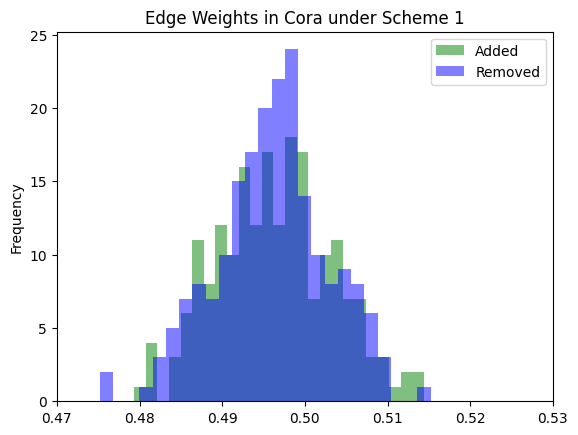

In [13]:
import matplotlib.pyplot as plt

added_edge_weights = [0.4987792372703552, 0.5002561807632446, 0.48542889952659607, 0.5028982758522034, 0.5025754570960999, 0.4947783350944519, 0.4946167469024658, 0.49693697690963745, 0.4939696788787842, 0.4951477348804474, 0.5073537826538086, 0.49938884377479553, 0.4985008239746094, 0.5056302547454834, 0.5012348890304565, 0.49928292632102966, 0.49250876903533936, 0.4964936077594757, 0.49873432517051697, 0.4984467327594757, 0.5073211193084717, 0.4993285536766052, 0.48945942521095276, 0.4978139400482178, 0.49878251552581787, 0.5045778155326843, 0.4891206920146942, 0.4933176636695862, 0.4981987178325653, 0.4926297962665558, 0.5094941854476929, 0.4963081479072571, 0.48716840147972107, 0.48791417479515076, 0.5003510117530823, 0.4979255497455597, 0.4966278374195099, 0.5035402178764343, 0.4877505600452423, 0.4931641221046448, 0.4901284873485565, 0.4916045069694519, 0.4937705397605896, 0.4960784316062927, 0.5002860426902771, 0.48823943734169006, 0.4897419810295105, 0.49990931153297424, 0.5026853680610657, 0.4977538585662842, 0.4869692325592041, 0.48669037222862244, 0.4896238148212433, 0.4868588149547577, 0.4954407513141632, 0.4926149547100067, 0.49565139412879944, 0.4899178147315979, 0.5102846622467041, 0.5012542605400085, 0.4991912245750427, 0.4893190860748291, 0.5003846883773804, 0.4892006814479828, 0.49176129698753357, 0.49875199794769287, 0.5044412016868591, 0.5074006915092468, 0.5004587769508362, 0.49966809153556824, 0.5004426836967468, 0.4855685532093048, 0.4918556809425354, 0.4997060298919678, 0.4938931465148926, 0.49603649973869324, 0.49237146973609924, 0.4925839602947235, 0.4921905994415283, 0.4905354380607605, 0.5061338543891907, 0.49825963377952576, 0.49572834372520447, 0.4949648082256317, 0.4993295669555664, 0.49307653307914734, 0.5018158555030823, 0.5036783218383789, 0.4919899106025696, 0.49671533703804016, 0.4994204044342041, 0.49829429388046265, 0.5025177597999573, 0.4887582063674927, 0.5090058445930481, 0.4877200424671173, 0.4988107979297638, 0.48513710498809814, 0.4986419081687927, 0.501025378704071, 0.49844351410865784, 0.48604142665863037, 0.5014305114746094, 0.5023038387298584, 0.5130494832992554, 0.5035514831542969, 0.4875912368297577, 0.5001108050346375, 0.4960753619670868, 0.5045501589775085, 0.4947846531867981, 0.4921070337295532, 0.4793538749217987, 0.5021675825119019, 0.4944620132446289, 0.4960782527923584, 0.4906799793243408, 0.4986458122730255, 0.4989929497241974, 0.4855073392391205, 0.4936826229095459, 0.5037088990211487, 0.49502459168434143, 0.4911009967327118, 0.4920949637889862, 0.4901854693889618, 0.4935567378997803, 0.5025601983070374, 0.49800437688827515, 0.4887543022632599, 0.5059471726417542, 0.48809707164764404, 0.5012021660804749, 0.5089876651763916, 0.4972718060016632, 0.4936707019805908, 0.49977028369903564, 0.4864348769187927, 0.48175135254859924, 0.4925119876861572, 0.4837004840373993, 0.4867057204246521, 0.49759238958358765, 0.5065338015556335, 0.5051882266998291, 0.4968874752521515, 0.4919249713420868, 0.49713462591171265, 0.5043670535087585, 0.502792477607727, 0.4880717694759369, 0.503696620464325, 0.5144194960594177, 0.5019215941429138, 0.49497583508491516, 0.5059213638305664, 0.506134033203125, 0.4911184012889862, 0.4937712848186493, 0.4964334964752197, 0.4858090877532959, 0.4932594895362854, 0.4961509704589844, 0.4903109073638916, 0.4965323805809021, 0.5066490173339844, 0.5032010674476624, 0.4941139817237854, 0.4868316054344177, 0.4933023750782013, 0.5125885605812073, 0.4902152121067047, 0.49709755182266235, 0.495925635099411, 0.5125153660774231, 0.5058097839355469, 0.5085029006004333, 0.49137794971466064, 0.5080903172492981, 0.4949156939983368, 0.49423542618751526, 0.5086707472801208, 0.5001975297927856, 0.4815676212310791, 0.4842113256454468, 0.4960598945617676, 0.5058562755584717, 0.49152806401252747, 0.4973755180835724, 0.49542543292045593, 0.4878385066986084, 0.4849545955657959, 0.4867207109928131, 0.4820362627506256, 0.4821361303329468, 0.5050193071365356, 0.4905080199241638, 0.5040170550346375, 0.49067768454551697, 0.4928244650363922]
removed_edge_weights = [0.5016184449195862, 0.4998352527618408, 0.4912679195404053, 0.4983479678630829, 0.49918729066848755, 0.5011016726493835, 0.48951804637908936, 0.4928772449493408, 0.5019106268882751, 0.48760899901390076, 0.4954836070537567, 0.4947670102119446, 0.49907243251800537, 0.49762365221977234, 0.4913788437843323, 0.5005677938461304, 0.48062121868133545, 0.5078880190849304, 0.49488747119903564, 0.48974940180778503, 0.5049294233322144, 0.4973297417163849, 0.49618202447891235, 0.491230309009552, 0.4889974296092987, 0.4992208778858185, 0.4992409348487854, 0.5053750872612, 0.49837127327919006, 0.4998057186603546, 0.5008544325828552, 0.4878225028514862, 0.49863073229789734, 0.49733278155326843, 0.48960793018341064, 0.49611207842826843, 0.4998970329761505, 0.4965627193450928, 0.4944160580635071, 0.5069571733474731, 0.5077322721481323, 0.4902689754962921, 0.4914093315601349, 0.4961082339286804, 0.48678693175315857, 0.49504008889198303, 0.5057975649833679, 0.4751586616039276, 0.4961240291595459, 0.49594011902809143, 0.5058249235153198, 0.4968299865722656, 0.482739120721817, 0.4981081485748291, 0.49691852927207947, 0.4936032295227051, 0.4974375069141388, 0.4902007281780243, 0.4857023060321808, 0.4929625689983368, 0.5152131915092468, 0.48466408252716064, 0.49533164501190186, 0.4983785152435303, 0.4933125674724579, 0.4978363811969757, 0.5008514523506165, 0.5079490542411804, 0.49962180852890015, 0.49620455503463745, 0.49824419617652893, 0.4951934516429901, 0.4865536391735077, 0.5034675598144531, 0.5068519115447998, 0.5098105669021606, 0.509490966796875, 0.4986686706542969, 0.48820388317108154, 0.4957740902900696, 0.49627360701560974, 0.4889381527900696, 0.5034329295158386, 0.49600306153297424, 0.5032010674476624, 0.5023688673973083, 0.49995729327201843, 0.49294960498809814, 0.49586808681488037, 0.4941251277923584, 0.4942817687988281, 0.4997824430465698, 0.497501403093338, 0.4989969730377197, 0.48387137055397034, 0.4908912777900696, 0.4976317584514618, 0.49767664074897766, 0.4986572563648224, 0.5014494061470032, 0.5042611956596375, 0.4972842037677765, 0.4870492219924927, 0.4960673153400421, 0.49677640199661255, 0.48864826560020447, 0.49236956238746643, 0.5072183609008789, 0.4935598075389862, 0.4861025810241699, 0.4832906723022461, 0.4931977093219757, 0.4936096668243408, 0.5025449991226196, 0.507415771484375, 0.5057098269462585, 0.5007209777832031, 0.4937092959880829, 0.498932808637619, 0.4943847954273224, 0.4981691837310791, 0.4855617880821228, 0.4928557276725769, 0.4859468340873718, 0.49582216143608093, 0.4990389347076416, 0.48489484190940857, 0.4955484867095947, 0.4820859134197235, 0.4932822585105896, 0.49629294872283936, 0.4915781319141388, 0.5059854388237, 0.49840089678764343, 0.49866047501564026, 0.4910847544670105, 0.5042298436164856, 0.4990536868572235, 0.5075376033782959, 0.47566232085227966, 0.49508264660835266, 0.4963989555835724, 0.4952201545238495, 0.5040557384490967, 0.49676433205604553, 0.5032073855400085, 0.4926146864891052, 0.4922037422657013, 0.4851846396923065, 0.4923064410686493, 0.4937592148780823, 0.482800155878067, 0.4890126585960388, 0.5059317350387573, 0.5089560747146606, 0.5029144287109375, 0.4899108111858368, 0.5017244219779968, 0.4925577938556671, 0.49431973695755005, 0.49556368589401245, 0.490554541349411, 0.5050696730613708, 0.5029001235961914, 0.49484243988990784, 0.49905064702033997, 0.494415283203125, 0.5018120408058167, 0.488632470369339, 0.4844505190849304, 0.4925345778465271, 0.4909657835960388, 0.4857785403728485, 0.4936482906341553, 0.4953346848487854, 0.4866830110549927, 0.4954220950603485, 0.5001800060272217, 0.4840400815010071, 0.5053292512893677, 0.5069395303726196, 0.5033577680587769, 0.4998627007007599, 0.4965658187866211, 0.5018653273582458, 0.4966123700141907, 0.4916726052761078, 0.48667585849761963, 0.4926004409790039, 0.5004616975784302, 0.498991996049881, 0.4912252128124237, 0.5041360855102539, 0.48657217621803284, 0.4915773868560791, 0.49835512042045593, 0.4952819347381592, 0.5049100518226624, 0.4994801878929138, 0.49008074402809143]

plt.hist(added_edge_weights, alpha=0.5, bins=25, color='g', label='Added')
plt.hist(removed_edge_weights, alpha=0.5, bins=25, color='b', label='Removed')
plt.gca().set(title='Edge Weights in Cora under Scheme 1', ylabel='Frequency')
plt.xlim(0.47,0.53)
plt.legend();

## **Chameleon**

In [30]:
edge_weights = []
added_edge_mask_global = None
removed_edge_mask_global = None

added_edges = set()
removed_edges = set()

sdrf_att_experiment(
    name='Chameleon',
    max_steps=699,
    tau=34,
    removal_bound=39.25,
    undirected=False,
    data_dir='chameleon',
    sdrf_only=True,
    use_edge_type_indicator=True,
    use_bfc_edge_feat=True,
    hidden=[128],
    dropout=0.5354,
    seeds=test_seeds,
    test=True,
    lr=0.0170,
    weight_decay=0.3422,
    development_frac=-1.0, # 60/20/20 split
    device='cuda',
    optimizer='adam'
)

Processing...
Processing...
Done!
/usr/local/lib/python3.9/dist-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 24 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerform

Added 699 edges. Removed 699 edges.


Done!


  0%|          | 0/100 [00:00<?, ?it/s]

Mean accuracy: 44.90 +- 0.44%


In [ ]:
import matplotlib.pyplot as plt

edge_weights_mean = torch.mean(torch.stack(edge_weights), dim=0)
added_edge_weights = edge_weights_mean[added_edge_mask_global].squeeze()
removed_edge_weights = edge_weights_mean[removed_edge_mask_global].squeeze()

added_edge_weights = added_edge_weights.cpu().tolist()
removed_edge_weights = removed_edge_weights.cpu().tolist()

In [32]:
print(added_edge_weights)
print(removed_edge_weights)

[0.49774184823036194, 0.5004172325134277, 0.49907633662223816, 0.5009235739707947, 0.504974365234375, 0.4985637664794922, 0.5042400360107422, 0.49681663513183594, 0.4989009201526642, 0.502220094203949, 0.5000634789466858, 0.49862736463546753, 0.5013831853866577, 0.499417781829834, 0.5007609128952026, 0.4991248846054077, 0.5017401576042175, 0.5002745389938354, 0.501068115234375, 0.5013508796691895, 0.5022813081741333, 0.5002346634864807, 0.4987083077430725, 0.4989224374294281, 0.5021767020225525, 0.5030612349510193, 0.5021951794624329, 0.506439208984375, 0.5054701566696167, 0.5033289194107056, 0.5034871101379395, 0.5073851346969604, 0.5072402358055115, 0.5048927664756775, 0.5045072436332703, 0.5050634145736694, 0.5020846128463745, 0.5007100701332092, 0.5039973258972168, 0.49993696808815, 0.4990920424461365, 0.5030288696289062, 0.5131298899650574, 0.4996953010559082, 0.5082395672798157, 0.5056054592132568, 0.5025049448013306, 0.4997563660144806, 0.5076196193695068, 0.5050564408302307, 0.

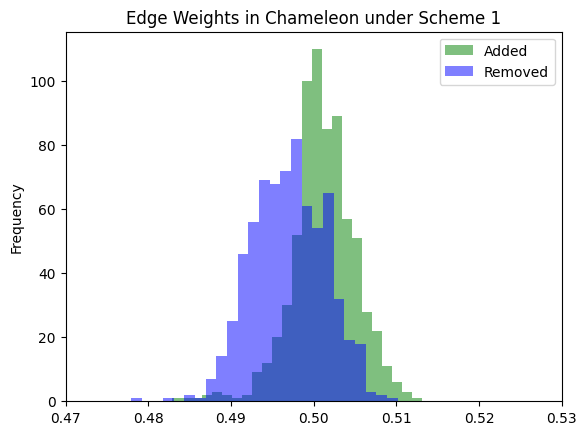

In [10]:
added_edge_weights = [0.49774184823036194, 0.5004172325134277, 0.49907633662223816, 0.5009235739707947, 0.504974365234375, 0.4985637664794922, 0.5042400360107422, 0.49681663513183594, 0.4989009201526642, 0.502220094203949, 0.5000634789466858, 0.49862736463546753, 0.5013831853866577, 0.499417781829834, 0.5007609128952026, 0.4991248846054077, 0.5017401576042175, 0.5002745389938354, 0.501068115234375, 0.5013508796691895, 0.5022813081741333, 0.5002346634864807, 0.4987083077430725, 0.4989224374294281, 0.5021767020225525, 0.5030612349510193, 0.5021951794624329, 0.506439208984375, 0.5054701566696167, 0.5033289194107056, 0.5034871101379395, 0.5073851346969604, 0.5072402358055115, 0.5048927664756775, 0.5045072436332703, 0.5050634145736694, 0.5020846128463745, 0.5007100701332092, 0.5039973258972168, 0.49993696808815, 0.4990920424461365, 0.5030288696289062, 0.5131298899650574, 0.4996953010559082, 0.5082395672798157, 0.5056054592132568, 0.5025049448013306, 0.4997563660144806, 0.5076196193695068, 0.5050564408302307, 0.4982910752296448, 0.49753013253211975, 0.49823063611984253, 0.500732421875, 0.4974694550037384, 0.5001219511032104, 0.494712769985199, 0.4973468780517578, 0.4926839768886566, 0.5003661513328552, 0.4993291199207306, 0.49923720955848694, 0.4999082684516907, 0.4976806342601776, 0.49890342354774475, 0.5039287805557251, 0.50360107421875, 0.5036414861679077, 0.503786563873291, 0.5056857466697693, 0.5065008401870728, 0.5004278421401978, 0.5015339851379395, 0.5027770400047302, 0.5018085241317749, 0.500424861907959, 0.49990779161453247, 0.500183641910553, 0.5008033514022827, 0.4993819296360016, 0.5046005249023438, 0.5009970664978027, 0.5033664107322693, 0.5020750761032104, 0.5014742612838745, 0.5025104284286499, 0.5051576495170593, 0.5002117156982422, 0.5008856058120728, 0.49389901757240295, 0.4933452308177948, 0.499061644077301, 0.5016578435897827, 0.5051580667495728, 0.5014263391494751, 0.4965415596961975, 0.505372941493988, 0.502652645111084, 0.4982200264930725, 0.49972325563430786, 0.4994412064552307, 0.5011310577392578, 0.5026848912239075, 0.5011372566223145, 0.49872061610221863, 0.5031458139419556, 0.5012430548667908, 0.5009439587593079, 0.49576011300086975, 0.49987557530403137, 0.49953213334083557, 0.5057963132858276, 0.5017775297164917, 0.5003451108932495, 0.500274658203125, 0.4989629089832306, 0.4988803267478943, 0.4978642165660858, 0.4995141327381134, 0.5010679364204407, 0.4942326545715332, 0.503816545009613, 0.5075284838676453, 0.49593159556388855, 0.5019817352294922, 0.5015774369239807, 0.49884235858917236, 0.49619486927986145, 0.502500057220459, 0.5074743032455444, 0.5022487640380859, 0.504547119140625, 0.5063993334770203, 0.5053485035896301, 0.5032446384429932, 0.5083618760108948, 0.5050354599952698, 0.4990134835243225, 0.5022808313369751, 0.49533095955848694, 0.5048442482948303, 0.5088525414466858, 0.5034695863723755, 0.5030823349952698, 0.5015875101089478, 0.5025944709777832, 0.5067423582077026, 0.5051289796829224, 0.5035118460655212, 0.49558502435684204, 0.49815934896469116, 0.49805498123168945, 0.4961552917957306, 0.4982699155807495, 0.5010151267051697, 0.4985126852989197, 0.4965311288833618, 0.5059205293655396, 0.49864763021469116, 0.49902403354644775, 0.5084322690963745, 0.502716064453125, 0.4986872971057892, 0.501319944858551, 0.4991966485977173, 0.49881216883659363, 0.5017984509468079, 0.501151978969574, 0.5009255409240723, 0.4974064826965332, 0.49964144825935364, 0.5014928579330444, 0.4990863800048828, 0.4994584023952484, 0.4936314821243286, 0.4975070059299469, 0.5051576495170593, 0.49565833806991577, 0.5023724436759949, 0.5006738901138306, 0.5060505270957947, 0.5043542385101318, 0.5047836303710938, 0.5026144981384277, 0.4991759955883026, 0.49603477120399475, 0.5102331042289734, 0.5027471780776978, 0.49621641635894775, 0.5026548504829407, 0.507935106754303, 0.5075663924217224, 0.49881216883659363, 0.4995098114013672, 0.49584704637527466, 0.49770113825798035, 0.5062485933303833, 0.5031967163085938, 0.5051250457763672, 0.5050740242004395, 0.5018405914306641, 0.5047705173492432, 0.5011211633682251, 0.5003742575645447, 0.49969482421875, 0.5014973878860474, 0.5001856088638306, 0.5021896958351135, 0.5014338493347168, 0.49701133370399475, 0.49941813945770264, 0.4987182915210724, 0.5013042688369751, 0.5026150941848755, 0.5007954835891724, 0.5000585317611694, 0.502227783203125, 0.5048137903213501, 0.504885196685791, 0.5028285980224609, 0.5049738883972168, 0.5015565156936646, 0.5034103393554688, 0.502108097076416, 0.5015048980712891, 0.5002346038818359, 0.5025348663330078, 0.5035305619239807, 0.5006433725357056, 0.4999004304409027, 0.5008848309516907, 0.501749575138092, 0.49997013807296753, 0.5000224113464355, 0.5000616908073425, 0.5008544921875, 0.503082811832428, 0.49986976385116577, 0.5077739357948303, 0.5065401792526245, 0.5056684017181396, 0.5042093992233276, 0.5024714469909668, 0.5015283226966858, 0.49364233016967773, 0.503753125667572, 0.5019537210464478, 0.5005186200141907, 0.5021337866783142, 0.4962252974510193, 0.5066202878952026, 0.5031353235244751, 0.5031203627586365, 0.5002129673957825, 0.5045246481895447, 0.5023898482322693, 0.50537109375, 0.5020221471786499, 0.5001735091209412, 0.5047395825386047, 0.49707281589508057, 0.5062861442565918, 0.5030117630958557, 0.4927367866039276, 0.4985937178134918, 0.5064162015914917, 0.48818907141685486, 0.5015033483505249, 0.5078336596488953, 0.5033165812492371, 0.497833251953125, 0.5016703605651855, 0.4980244040489197, 0.49685606360435486, 0.500977098941803, 0.4982019364833832, 0.497322678565979, 0.49643146991729736, 0.49741411209106445, 0.4941023588180542, 0.4978918731212616, 0.49638885259628296, 0.4912205636501312, 0.5029503107070923, 0.49706020951271057, 0.4948115050792694, 0.4983825385570526, 0.49987778067588806, 0.49905455112457275, 0.5046921968460083, 0.4969997704029083, 0.49872642755508423, 0.49712374806404114, 0.49851229786872864, 0.4965415596961975, 0.4984106719493866, 0.49452972412109375, 0.5036540627479553, 0.5063395500183105, 0.5060723423957825, 0.5032958388328552, 0.5062045454978943, 0.5001855492591858, 0.5008519887924194, 0.49971532821655273, 0.5014419555664062, 0.49868521094322205, 0.4985557496547699, 0.5028910040855408, 0.5031661987304688, 0.49890896677970886, 0.500885009765625, 0.4989834427833557, 0.5012893080711365, 0.5024489164352417, 0.5012898445129395, 0.5009056329727173, 0.50667405128479, 0.5112589597702026, 0.5081275701522827, 0.5082933306694031, 0.5118097066879272, 0.5035406351089478, 0.5098246335983276, 0.508150041103363, 0.5001931190490723, 0.499473512172699, 0.4985370635986328, 0.4982304573059082, 0.4853815734386444, 0.49849650263786316, 0.5016704201698303, 0.5022296905517578, 0.4952082335948944, 0.5026756525039673, 0.4998380243778229, 0.5009161233901978, 0.49934908747673035, 0.499817430973053, 0.5048006772994995, 0.5063170790672302, 0.5078354477882385, 0.4989299774169922, 0.5026034116744995, 0.5002159476280212, 0.4990023672580719, 0.4951094090938568, 0.49534034729003906, 0.502596378326416, 0.4976806342601776, 0.5021356344223022, 0.5037136673927307, 0.4973430633544922, 0.5017070174217224, 0.5051058530807495, 0.5009865760803223, 0.49927717447280884, 0.5005397796630859, 0.49895477294921875, 0.5013522505760193, 0.4996737539768219, 0.5007404088973999, 0.4977492392063141, 0.4996262192726135, 0.5005192756652832, 0.5063402056694031, 0.5028174519538879, 0.49488070607185364, 0.4945290982723236, 0.5049413442611694, 0.4972324073314667, 0.49727386236190796, 0.49962425231933594, 0.4994807243347168, 0.5024204254150391, 0.5006003379821777, 0.4993596076965332, 0.500734269618988, 0.49845319986343384, 0.5003276467323303, 0.501190185546875, 0.5026015043258667, 0.5028692483901978, 0.5024924278259277, 0.502199649810791, 0.5029221773147583, 0.5016176104545593, 0.5023269057273865, 0.5039578676223755, 0.5026251077651978, 0.4986286163330078, 0.4944559335708618, 0.49369052052497864, 0.5008544921875, 0.498526930809021, 0.49836212396621704, 0.5032573938369751, 0.5048908591270447, 0.4954834282398224, 0.4947736859321594, 0.5013447403907776, 0.49924710392951965, 0.482920378446579, 0.5045261383056641, 0.4993281364440918, 0.5006203651428223, 0.5040382742881775, 0.4867883622646332, 0.49994710087776184, 0.498659610748291, 0.49951183795928955, 0.5024619102478027, 0.49981704354286194, 0.5055155754089355, 0.501157283782959, 0.5003973841667175, 0.5004482269287109, 0.5063775777816772, 0.5012842416763306, 0.5105510354042053, 0.5093914270401001, 0.5024033784866333, 0.5043640732765198, 0.489310622215271, 0.5019835233688354, 0.5029608011245728, 0.5038527846336365, 0.49936115741729736, 0.5039677619934082, 0.4936217963695526, 0.49853312969207764, 0.5045477151870728, 0.5060960054397583, 0.4995422661304474, 0.5026853680610657, 0.4991455674171448, 0.4998759627342224, 0.4987793266773224, 0.5035302042961121, 0.4967627227306366, 0.5052569508552551, 0.5026569366455078, 0.4985446035861969, 0.49848228693008423, 0.5044941902160645, 0.5063475966453552, 0.5029072761535645, 0.5076575875282288, 0.4989542067050934, 0.5061260461807251, 0.4976811707019806, 0.5045394897460938, 0.49988028407096863, 0.5003887414932251, 0.5048747658729553, 0.5049762725830078, 0.5061055421829224, 0.5018690824508667, 0.5042339563369751, 0.5062786936759949, 0.5029905438423157, 0.4996853768825531, 0.5035193562507629, 0.5033969879150391, 0.5012201070785522, 0.5004552602767944, 0.5035194754600525, 0.49863624572753906, 0.501528263092041, 0.501798152923584, 0.5021978616714478, 0.5023809671401978, 0.49781280755996704, 0.4976273477077484, 0.5039972066879272, 0.5064672231674194, 0.5045394897460938, 0.4997177720069885, 0.5019326210021973, 0.49996742606163025, 0.499412477016449, 0.5041524171829224, 0.5000094175338745, 0.5053200125694275, 0.500661313533783, 0.5053194165229797, 0.5084130167961121, 0.4999414384365082, 0.5044880509376526, 0.5006484389305115, 0.5002957582473755, 0.5009361505508423, 0.500404417514801, 0.5047932863235474, 0.500272810459137, 0.5044867396354675, 0.5032141804695129, 0.50244140625, 0.4998449981212616, 0.5011903047561646, 0.5002422332763672, 0.49784141778945923, 0.4992271363735199, 0.5003986358642578, 0.4971013069152832, 0.5008316040039062, 0.4847327470779419, 0.5036640763282776, 0.4988327622413635, 0.5014572143554688, 0.4986671805381775, 0.49778231978416443, 0.5082605481147766, 0.5051264762878418, 0.502044677734375, 0.5032957792282104, 0.499204158782959, 0.5090734362602234, 0.5021973252296448, 0.504271924495697, 0.496085524559021, 0.4999789297580719, 0.49816954135894775, 0.4869486689567566, 0.5017923712730408, 0.49664098024368286, 0.501380980014801, 0.4997788369655609, 0.5004677772521973, 0.5096440315246582, 0.49837446212768555, 0.49678561091423035, 0.4974994659423828, 0.5011010766029358, 0.5035324692726135, 0.49786311388015747, 0.4995802938938141, 0.4989643394947052, 0.5013433694839478, 0.49913591146469116, 0.4960099160671234, 0.5005181431770325, 0.496002197265625, 0.49829035997390747, 0.49930015206336975, 0.5007418394088745, 0.49741554260253906, 0.4997483491897583, 0.5006719827651978, 0.49640852212905884, 0.4949849843978882, 0.5033893585205078, 0.503450334072113, 0.5022589564323425, 0.5050129890441895, 0.501228392124176, 0.5023826956748962, 0.5039597153663635, 0.5033262372016907, 0.5005207061767578, 0.49878886342048645, 0.5047686696052551, 0.5085063576698303, 0.5003056526184082, 0.4963071942329407, 0.501950740814209, 0.5052509307861328, 0.4991989731788635, 0.5056432485580444, 0.5049745440483093, 0.5092796683311462, 0.5072842836380005, 0.5043869018554688, 0.5035399794578552, 0.5041505098342896, 0.5001835823059082, 0.5019249320030212, 0.503939151763916, 0.5028150677680969, 0.5045090913772583, 0.49915310740470886, 0.5009467005729675, 0.494558185338974, 0.5004978775978088, 0.48950210213661194, 0.495849072933197, 0.4930017590522766, 0.4926733672618866, 0.495735764503479, 0.49952128529548645, 0.4996623694896698, 0.49985694885253906, 0.49912315607070923, 0.49795547127723694, 0.5078123211860657, 0.5030921101570129, 0.5021891593933105, 0.5031437873840332, 0.502835750579834, 0.500060498714447, 0.500059187412262, 0.5009153485298157, 0.4995097219944, 0.5010979771614075, 0.5083948373794556, 0.500974178314209, 0.50201416015625, 0.49863678216934204, 0.5002523064613342, 0.49911296367645264, 0.5088171362876892, 0.5002142190933228, 0.5021337270736694, 0.5057602524757385, 0.4980463981628418, 0.5031358003616333, 0.5006021857261658, 0.5014057755470276, 0.4967956244945526, 0.5030193328857422, 0.48813074827194214, 0.4980674684047699, 0.4997177720069885, 0.49803876876831055, 0.5014854669570923, 0.5040587186813354, 0.5019232630729675, 0.5027385354042053, 0.5101926922798157, 0.5032350420951843, 0.5022664070129395, 0.5049232244491577, 0.5039952993392944, 0.5004292726516724, 0.5032655000686646, 0.5061670541763306, 0.5028401613235474, 0.5024638175964355, 0.5032124519348145, 0.4996332824230194, 0.49610185623168945, 0.5005186200141907, 0.5006128549575806, 0.5025230646133423, 0.5032328367233276, 0.5037131309509277, 0.5034390091896057, 0.5024814009666443, 0.5055462718009949, 0.5035494565963745, 0.501707136631012, 0.4999413788318634, 0.49964192509651184, 0.5032349228858948, 0.4879538118839264, 0.5029017329216003, 0.49897241592407227, 0.5031335353851318, 0.5068739056587219, 0.5009360313415527, 0.508493185043335, 0.5057771801948547, 0.5073931217193604, 0.5052413940429688, 0.5046287178993225, 0.4990819990634918, 0.5024438500404358, 0.4993586242198944, 0.49923452734947205, 0.4984132647514343, 0.4964885115623474, 0.5006403923034668, 0.49533846974372864, 0.5036946535110474, 0.4996112883090973, 0.5003666877746582, 0.5050657987594604, 0.5036697387695312, 0.50396728515625, 0.5069960951805115, 0.5038450360298157, 0.5063092112541199, 0.49925941228866577, 0.5002439618110657, 0.5012916326522827, 0.5001319646835327, 0.49971768260002136, 0.500795841217041, 0.502871036529541, 0.4997769594192505, 0.4989909827709198, 0.5056232213973999, 0.510164737701416, 0.5073871612548828, 0.5112078785896301, 0.5072022080421448, 0.5079650282859802, 0.49209389090538025, 0.4918210804462433]
removed_edge_weights = [0.4984659254550934, 0.4981173574924469, 0.5050888657569885, 0.501747190952301, 0.49743446707725525, 0.5001301765441895, 0.5014972686767578, 0.4978351294994354, 0.5012131929397583, 0.5034765601158142, 0.4983421564102173, 0.5001601576805115, 0.49306291341781616, 0.4906896650791168, 0.4966430366039276, 0.5047987699508667, 0.5008569955825806, 0.49597403407096863, 0.49981892108917236, 0.4973755180835724, 0.49611425399780273, 0.4899980425834656, 0.5029508471488953, 0.5014322996139526, 0.49179279804229736, 0.4962767958641052, 0.5000633597373962, 0.49267831444740295, 0.49347737431526184, 0.49568742513656616, 0.4989399313926697, 0.4922277331352234, 0.488485187292099, 0.5015178918838501, 0.494590163230896, 0.5031948685646057, 0.49659156799316406, 0.4928186535835266, 0.493431031703949, 0.4779053032398224, 0.49200454354286194, 0.48902150988578796, 0.50567626953125, 0.4901124835014343, 0.5022664666175842, 0.505797803401947, 0.4996849298477173, 0.4942704439163208, 0.4945887625217438, 0.4976276457309723, 0.5020471811294556, 0.5012226104736328, 0.5016254782676697, 0.49967437982559204, 0.5016080141067505, 0.495086133480072, 0.5014743804931641, 0.5004964470863342, 0.4999309480190277, 0.5016504526138306, 0.501190185546875, 0.49622398614883423, 0.4956766366958618, 0.49108070135116577, 0.48636069893836975, 0.49279800057411194, 0.49566391110420227, 0.4889138340950012, 0.4911518394947052, 0.4895934760570526, 0.492530882358551, 0.4933859705924988, 0.49961331486701965, 0.4884539842605591, 0.48959416151046753, 0.4916784167289734, 0.49275901913642883, 0.4898148477077484, 0.49422967433929443, 0.4925130307674408, 0.4928888976573944, 0.49307265877723694, 0.4926757216453552, 0.49438223242759705, 0.4919641315937042, 0.4918847680091858, 0.48949185013771057, 0.49375393986701965, 0.4916096031665802, 0.49251312017440796, 0.4928892254829407, 0.4926452338695526, 0.4918498694896698, 0.49346861243247986, 0.4915975034236908, 0.49023422598838806, 0.49246281385421753, 0.4932575821876526, 0.49201223254203796, 0.488106369972229, 0.49184930324554443, 0.4912415146827698, 0.49294981360435486, 0.4920329749584198, 0.48723331093788147, 0.49282020330429077, 0.4909387230873108, 0.5003868341445923, 0.49877944588661194, 0.4987277388572693, 0.5018081068992615, 0.49952128529548645, 0.5025858879089355, 0.4961523711681366, 0.5050027966499329, 0.4977641701698303, 0.494326114654541, 0.49325546622276306, 0.4989648759365082, 0.5002971291542053, 0.5005817413330078, 0.49102798104286194, 0.496055006980896, 0.4992676377296448, 0.5016809701919556, 0.5080950260162354, 0.5033894777297974, 0.5012817978858948, 0.5053424835205078, 0.49387428164482117, 0.4964390993118286, 0.49761962890625, 0.49112769961357117, 0.4913102090358734, 0.491178035736084, 0.4916101396083832, 0.49655917286872864, 0.4908752739429474, 0.49478355050086975, 0.5003045201301575, 0.4904993176460266, 0.4893213212490082, 0.4947209656238556, 0.49285951256752014, 0.4931311309337616, 0.496286541223526, 0.4997557997703552, 0.48960182070732117, 0.49157458543777466, 0.49453940987586975, 0.5029886960983276, 0.49995988607406616, 0.5016175508499146, 0.49890342354774475, 0.49352774024009705, 0.4987207353115082, 0.5022296905517578, 0.498380184173584, 0.498443603515625, 0.4999614357948303, 0.5014647245407104, 0.5016254782676697, 0.5039674043655396, 0.4974142014980316, 0.5008751153945923, 0.49219566583633423, 0.49887096881866455, 0.496828556060791, 0.4992145597934723, 0.49706968665122986, 0.4996547996997833, 0.5005168914794922, 0.49451684951782227, 0.49848416447639465, 0.5011672377586365, 0.49355074763298035, 0.5040302872657776, 0.495567262172699, 0.4994277060031891, 0.5014119148254395, 0.497780442237854, 0.49629729986190796, 0.49677515029907227, 0.4915156066417694, 0.5000400543212891, 0.4953386187553406, 0.4975299537181854, 0.5043330192565918, 0.4949742555618286, 0.4961244463920593, 0.4975285530090332, 0.49707093834877014, 0.4917902946472168, 0.49674221873283386, 0.4994511902332306, 0.4946904480457306, 0.5000686645507812, 0.5041733980178833, 0.4948628842830658, 0.4950871467590332, 0.5048834085464478, 0.4984970688819885, 0.49612173438072205, 0.48821955919265747, 0.49883025884628296, 0.4989314079284668, 0.4994792640209198, 0.50433349609375, 0.5037617683410645, 0.49538931250572205, 0.5014858841896057, 0.5068265795707703, 0.50274658203125, 0.49233242869377136, 0.5024818181991577, 0.49869734048843384, 0.49395811557769775, 0.49269846081733704, 0.49010446667671204, 0.49765264987945557, 0.49835455417633057, 0.5001926422119141, 0.5019512176513672, 0.5047078132629395, 0.5032442808151245, 0.49370333552360535, 0.49737611413002014, 0.499412477016449, 0.49585214257240295, 0.49635830521583557, 0.48941296339035034, 0.49495503306388855, 0.49093830585479736, 0.49597373604774475, 0.4890771508216858, 0.48702794313430786, 0.49777156114578247, 0.5019611120223999, 0.4968038499355316, 0.4966963529586792, 0.49804624915122986, 0.5005518198013306, 0.49520057439804077, 0.49558496475219727, 0.50146484375, 0.4958396553993225, 0.5050888657569885, 0.49270883202552795, 0.5004578828811646, 0.49585214257240295, 0.4999999701976776, 0.5000075697898865, 0.495880126953125, 0.5005183219909668, 0.49606263637542725, 0.49576807022094727, 0.4988713562488556, 0.5013956427574158, 0.4956684112548828, 0.5031052827835083, 0.49608609080314636, 0.49590057134628296, 0.4979249835014343, 0.4890466034412384, 0.492342472076416, 0.49621376395225525, 0.4915447235107422, 0.494926393032074, 0.4878843426704407, 0.4875773787498474, 0.4951476752758026, 0.4920024871826172, 0.49368494749069214, 0.494638592004776, 0.49124088883399963, 0.4972248375415802, 0.4922102093696594, 0.5030132532119751, 0.4971919059753418, 0.4960351884365082, 0.49432578682899475, 0.4966450035572052, 0.48892417550086975, 0.4994182586669922, 0.4946085810661316, 0.4979647397994995, 0.5017094612121582, 0.4925333857536316, 0.4910666346549988, 0.489876389503479, 0.4916081726551056, 0.491088330745697, 0.49629974365234375, 0.49002137780189514, 0.4928893744945526, 0.49112942814826965, 0.498359739780426, 0.5019931793212891, 0.494558185338974, 0.5041203498840332, 0.5006719827651978, 0.5004191994667053, 0.49584949016571045, 0.49449899792671204, 0.5021438598632812, 0.49651092290878296, 0.499977171421051, 0.5040972828865051, 0.49716997146606445, 0.4969387352466583, 0.49491357803344727, 0.49298301339149475, 0.49407193064689636, 0.49438410997390747, 0.49578094482421875, 0.4894618093967438, 0.4937443435192108, 0.49325767159461975, 0.49422258138656616, 0.49310100078582764, 0.4936828911304474, 0.4945068657398224, 0.4934183359146118, 0.49008244276046753, 0.4933374226093292, 0.4915688931941986, 0.4941507577896118, 0.4901200234889984, 0.4915471076965332, 0.49328359961509705, 0.4974360167980194, 0.49388644099235535, 0.491966187953949, 0.4880472719669342, 0.4959615468978882, 0.49622389674186707, 0.49295058846473694, 0.49284881353378296, 0.4947815239429474, 0.5003150701522827, 0.49265339970588684, 0.5017108917236328, 0.5003962516784668, 0.5058065056800842, 0.49893391132354736, 0.5012288689613342, 0.4978109300136566, 0.49536946415901184, 0.4897359311580658, 0.4892553687095642, 0.49421119689941406, 0.5041292309761047, 0.4991855025291443, 0.49594128131866455, 0.5016080141067505, 0.49654942750930786, 0.5012288689613342, 0.497769832611084, 0.495729923248291, 0.49807944893836975, 0.504852294921875, 0.49585774540901184, 0.5010980367660522, 0.4977511167526245, 0.49465736746788025, 0.499356746673584, 0.5036395788192749, 0.49913740158081055, 0.49532124400138855, 0.5052087306976318, 0.4946187734603882, 0.4971389174461365, 0.493507444858551, 0.4975990355014801, 0.498359739780426, 0.5019931793212891, 0.494558185338974, 0.49600014090538025, 0.4960612952709198, 0.5054906606674194, 0.5064390301704407, 0.49978402256965637, 0.5036104917526245, 0.49604281783103943, 0.4986652731895447, 0.5050073862075806, 0.497713565826416, 0.49832138419151306, 0.5040568113327026, 0.49801430106163025, 0.4978407919406891, 0.500173032283783, 0.49456533789634705, 0.4983729422092438, 0.5020142793655396, 0.5015469789505005, 0.50164794921875, 0.49853581190109253, 0.5029522180557251, 0.5062261819839478, 0.4963894188404083, 0.4975074827671051, 0.497802197933197, 0.49516811966896057, 0.49941059947013855, 0.49848416447639465, 0.495208740234375, 0.4989948272705078, 0.5056057572364807, 0.49762216210365295, 0.49813026189804077, 0.4963373839855194, 0.4956441819667816, 0.49802643060684204, 0.49761199951171875, 0.49845367670059204, 0.49751847982406616, 0.49739840626716614, 0.497103214263916, 0.49336761236190796, 0.5013713836669922, 0.49960562586784363, 0.496772825717926, 0.4963587522506714, 0.49331727623939514, 0.49968522787094116, 0.5024493336677551, 0.4933268129825592, 0.49916788935661316, 0.4986571967601776, 0.4988708198070526, 0.49990907311439514, 0.4987870156764984, 0.5040969252586365, 0.5023218989372253, 0.5041601657867432, 0.5029608011245728, 0.5081865787506104, 0.49914610385894775, 0.49881741404533386, 0.49670660495758057, 0.4950847327709198, 0.4987793266773224, 0.4933985471725464, 0.4921773076057434, 0.49578604102134705, 0.5002117156982422, 0.49822795391082764, 0.5010992288589478, 0.5044935941696167, 0.4962257742881775, 0.49450936913490295, 0.5002748370170593, 0.49786579608917236, 0.4973851144313812, 0.5021151304244995, 0.4942544996738434, 0.4978661835193634, 0.5019307136535645, 0.495053768157959, 0.49336811900138855, 0.5005207061767578, 0.4948198199272156, 0.502443790435791, 0.49588263034820557, 0.49968665838241577, 0.4974594712257385, 0.5012288689613342, 0.4998493194580078, 0.4934087097644806, 0.48998191952705383, 0.5026220083236694, 0.5060753226280212, 0.4996418356895447, 0.5034489631652832, 0.5016560554504395, 0.49724581837654114, 0.4944859743118286, 0.5055618286132812, 0.500730037689209, 0.49541234970092773, 0.5011906623840332, 0.498934268951416, 0.4910583198070526, 0.49695077538490295, 0.494537353515625, 0.5101618766784668, 0.49545353651046753, 0.4995447099208832, 0.49637046456336975, 0.494903564453125, 0.49550387263298035, 0.4934087097644806, 0.4940389096736908, 0.5026853680610657, 0.49820947647094727, 0.4996027946472168, 0.49817097187042236, 0.5032733678817749, 0.4975285530090332, 0.5019931793212891, 0.494558185338974, 0.498359739780426, 0.49691519141197205, 0.500053346157074, 0.4968777298927307, 0.4939556121826172, 0.49823251366615295, 0.49479106068611145, 0.4970702826976776, 0.49838459491729736, 0.5020236372947693, 0.49457037448883057, 0.5004858374595642, 0.49529021978378296, 0.5011521577835083, 0.5018391609191895, 0.5026251077651978, 0.5008543729782104, 0.5033259391784668, 0.49985507130622864, 0.497713565826416, 0.4978961944580078, 0.4972759187221527, 0.500856876373291, 0.49391883611679077, 0.4944859743118286, 0.4983729422092438, 0.5020142793655396, 0.49456533789634705, 0.501004695892334, 0.5055155754089355, 0.4934595227241516, 0.493600994348526, 0.494954913854599, 0.49551182985305786, 0.49498695135116577, 0.48990121483802795, 0.4971213638782501, 0.4983731210231781, 0.494576096534729, 0.49459630250930786, 0.49839070439338684, 0.502044677734375, 0.49936166405677795, 0.5020347237586975, 0.4958782494068146, 0.5037020444869995, 0.4966354966163635, 0.4938437044620514, 0.5031414031982422, 0.49899089336395264, 0.4965110123157501, 0.5006123781204224, 0.4973754584789276, 0.4914328455924988, 0.4988727569580078, 0.49947869777679443, 0.494576096534729, 0.49640703201293945, 0.49756109714508057, 0.4987277388572693, 0.5016809701919556, 0.49652302265167236, 0.49554648995399475, 0.49810993671417236, 0.4970780611038208, 0.501192569732666, 0.494102418422699, 0.49215638637542725, 0.4960710406303406, 0.5005821585655212, 0.5042803287506104, 0.496673583984375, 0.498893678188324, 0.4953841269016266, 0.4969687759876251, 0.4939677119255066, 0.5021077990531921, 0.49807724356651306, 0.5023093223571777, 0.49762922525405884, 0.5017493963241577, 0.49621376395225525, 0.4999600648880005, 0.5029901266098022, 0.49848368763923645, 0.5012302398681641, 0.49495458602905273, 0.49868708848953247, 0.4998784065246582, 0.4970298409461975, 0.4957273304462433, 0.5029831528663635, 0.4997047185897827, 0.4971313774585724, 0.494680255651474, 0.49927565455436707, 0.5028667449951172, 0.4950479567050934, 0.49334514141082764, 0.4983614683151245, 0.5004889369010925, 0.5004047751426697, 0.4923686683177948, 0.5013937950134277, 0.49969276785850525, 0.5014244318008423, 0.4969705641269684, 0.4976600408554077, 0.4968259930610657, 0.5017095804214478, 0.5008856058120728, 0.49515584111213684, 0.5047831535339355, 0.49150794744491577, 0.49195343255996704, 0.4923420250415802, 0.4920271635055542, 0.4913732409477234, 0.49465957283973694, 0.49359336495399475, 0.48897531628608704, 0.4913732409477234, 0.5068670511245728, 0.4978032410144806, 0.4944762885570526, 0.4902324080467224, 0.5026835203170776, 0.5006808638572693, 0.4902570843696594, 0.49198222160339355, 0.490714430809021, 0.49289193749427795, 0.49010398983955383, 0.4962182343006134, 0.49077552556991577, 0.48898521065711975, 0.49433183670043945, 0.5015850067138672, 0.506070613861084, 0.4988122880458832, 0.4954834282398224, 0.4976806938648224, 0.49523940682411194, 0.5054222941398621, 0.49334514141082764, 0.4983614683151245, 0.5004889369010925, 0.4950479567050934, 0.4845965504646301, 0.48541203141212463, 0.49218493700027466, 0.49558496475219727, 0.49948182702064514, 0.5017800331115723, 0.4956893026828766, 0.4821389317512512, 0.4945780038833618, 0.4984031319618225, 0.502044677734375, 0.4938271939754486, 0.5016995072364807, 0.4933757483959198, 0.5026321411132812, 0.5003992319107056, 0.4986667335033417, 0.4972628653049469, 0.5006183981895447, 0.49499765038490295, 0.49423471093177795, 0.49608561396598816, 0.49252253770828247, 0.4959718585014343, 0.495145320892334, 0.4923730492591858, 0.49960261583328247, 0.5035419464111328, 0.497159481048584, 0.49737343192100525, 0.49579092860221863, 0.49789494276046753, 0.4981084167957306, 0.4946085810661316, 0.5036397576332092, 0.492338091135025, 0.4983743727207184, 0.500487744808197, 0.49456721544265747, 0.4966425597667694, 0.4899878203868866, 0.4927673637866974, 0.49133551120758057, 0.4925231635570526, 0.48971572518348694, 0.4911576509475708, 0.49081674218177795, 0.4906693994998932, 0.5053992867469788]

plt.hist(added_edge_weights, alpha=0.5, bins=25, color='g', label='Added')
plt.hist(removed_edge_weights, alpha=0.5, bins=25, color='b', label='Removed')
plt.gca().set(title='Edge Weights in Chameleon under Scheme 1', ylabel='Frequency')
plt.xlim(0.47,0.53)
plt.legend();